In [ ]:
from masi import timeseries_to_supervised,difference,inverse_difference,scale,invert_scale,fit_lstm
from pandas import Series, DataFrame, concat, read_excel, datetime
from pandas.plotting import autocorrelation_plot
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from math import sqrt
from matplotlib import pyplot
import numpy

C:\Users\Dell\Desktop\PROJECTS\masi.py:5: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import Series, DataFrame, concat, read_excel, datetime
C:\Users\Dell\Desktop\PROJECTS\masi.py:7: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


C:\Users\Dell\AppData\Local\Temp\ipykernel_12944\3229621495.py:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import Series, DataFrame, concat, read_excel, datetime


In [ ]:
# Import data
series = read_excel('masi.xlsx', header=0, index_col=0, squeeze=True, parse_dates=True)

C:\Users\Dell\AppData\Local\Temp\ipykernel_12944\1037905680.py:2: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  series = read_excel('masi.xlsx', header=0, index_col=0, squeeze=True, parse_dates=True)


In [ ]:
series.head(10)

Date 
2023-12-08 00:00:00.000    11885.32
2023-12-07 00:00:00.000    11827.02
2023-12-06 00:00:00.000    11757.60
2023-12-05 00:00:00.000    11759.51
2023-12-04 00:00:00.000    11728.06
2023-12-01 00:00:00.000    11748.19
2023-11-30 00:00:00.000    11781.56
2023-11-29 00:00:00.000    11784.33
2023-11-28 00:00:00.000    11775.17
2023-11-27 00:00:00.000    11843.79
Name: cloture, dtype: float64

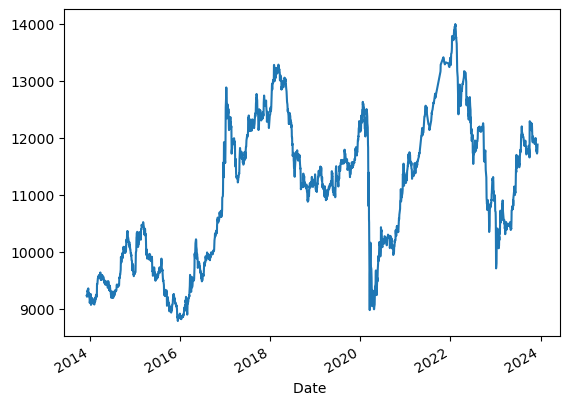

In [ ]:

# Plot the data
series.plot()
pyplot.show()

# verifiy if the time series white noise , random walk and staionarity

## white noise

In [ ]:
series.describe()

count     2366.000000
mean     11007.492700
std       1228.034432
min       8796.650391
25%       9927.517578
50%      11159.635254
75%      11969.242559
max      13991.470000
Name: cloture, dtype: float64

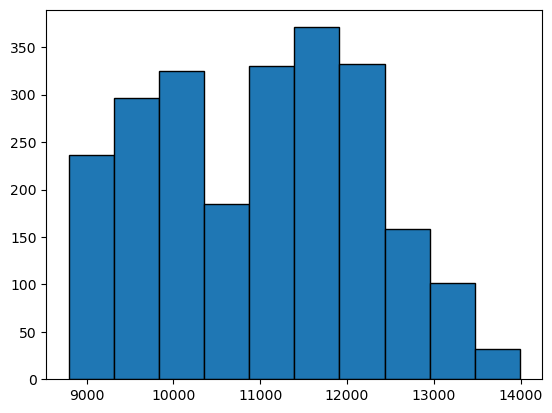

In [ ]:
pyplot.hist(series,edgecolor = "black")
pyplot.show()

la distrubution statistique n'est pas gaussien de plus ,
pas d'auto-correlation avec laged value donc otre series ni un white noise ni random walk

## Stationarity

In [ ]:
# calculate the stationarity
from statsmodels.tsa.stattools import adfuller
# statistical test
result = adfuller(series)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.039077
p-value: 0.269706
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567


puisque p-value=0.27 >0.05 donc notre series et non stationanire , pour la rendre stationnaire on va utiliser la methode de
differencing

In [ ]:
# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

In [ ]:
# transform data to be stationary
raw_values = series.values
diff_values = difference(raw_values, 3)

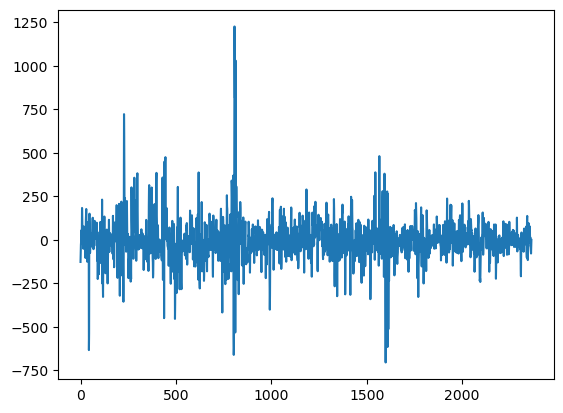

In [ ]:
diff_values.plot()
pyplot.show()

# Creation des sequences pour machine learning

In [ ]:
# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag):
    df = DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag + 1)]
    columns.append(df)
    df = concat(columns, axis=1)
    df.fillna(0, inplace=True)
    return df

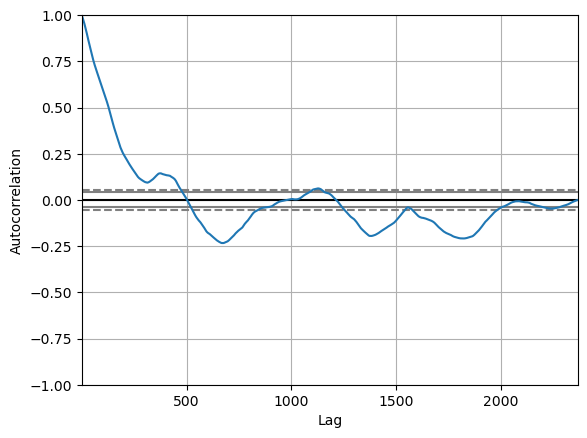

In [ ]:
autocorrelation_plot(series)
pyplot.show()

 Nous prévoyons d'utiliser environ 10 valeurs de retard pour former nos séquences,
car nous constatons une corrélation forte et significative.

In [ ]:
# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values,10)
supervised_values = supervised.values

In [ ]:
supervised.head(10)

,0,0,0,0,0,0,0,0,0,0,0
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,-125.81
1,-125.81,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,-98.96
2,-98.96,-125.81,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,-9.41
3,-9.41,-98.96,-125.81,0.00,0.00,0.00,0.00,0.00,0.00,0.0,22.05
4,22.05,-9.41,-98.96,-125.81,0.00,0.00,0.00,0.00,0.00,0.0,56.27
5,56.27,22.05,-9.41,-98.96,-125.81,0.00,0.00,0.00,0.00,0.0,26.98
6,26.98,56.27,22.05,-9.41,-98.96,-125.81,0.00,0.00,0.00,0.0,62.23
7,62.23,26.98,56.27,22.05,-9.41,-98.96,-125.81,0.00,0.00,0.0,173.34
8,173.34,62.23,26.98,56.27,22.05,-9.41,-98.96,-125.81,0.00,0.0,201.00
9,201.00,173.34,62.23,26.98,56.27,22.05,-9.41,-98.96,-125.81,0.0,155.92


In [ ]:
# Determine the split index
split_index = int(0.8 * len(supervised_values))

In [ ]:
 len(supervised_values)

2363

In [ ]:
# Split data into train and test-sets
train, test = supervised_values[0:split_index], supervised_values[split_index:]

In [ ]:
# scale train and test data to [-1, 1]
def scale(train, test):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled

# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
    new_row = [x for x in X] + [value]
    array = numpy.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]

In [ ]:
# Split data into train and test-sets
train, test = supervised_values[0:split_index], supervised_values[split_index:]

# Creation et entrainememnt de modele

In [ ]:
# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])

    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(1))

    model.compile(loss='mean_squared_error', optimizer='adam')

    for i in range(nb_epoch):
        try:
            model.fit(X, y, epochs=1, batch_size=batch_size, verbose=1, shuffle=False)
        except Exception as e:
            print(f"Error in epoch {i+1}: {e}")
        model.reset_states()
    return model

In [ ]:
# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)

In [ ]:
# fit the model
lstm_model = fit_lstm(train_scaled, 32, 500, 50)

49/60 [=======================>......] - ETA: 0s - loss: 0.0286Error in epoch 1: Graph execution error:

Detected at node gradient_tape/mean_squared_error/BroadcastGradientArgs defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "C:\Users\Dell\anaconda3\Lib\site-packages\traitlets\config\application.py", line 992, in launch_instance

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 711, in start

  File "C:\Users\Dell\anaconda3\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 607, in run_forever

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 1922, in _run_once

  File "C:\Users\Dell\anaconda3\Lib\asyncio\events.py", line 80, in _run

  File "C:\Users\Dell\anacon

49/60 [=======================>......] - ETA: 0s - loss: 0.0132Error in epoch 4: Graph execution error:

Detected at node gradient_tape/mean_squared_error/BroadcastGradientArgs defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "C:\Users\Dell\anaconda3\Lib\site-packages\traitlets\config\application.py", line 992, in launch_instance

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 711, in start

  File "C:\Users\Dell\anaconda3\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 607, in run_forever

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 1922, in _run_once

  File "C:\Users\Dell\anaconda3\Lib\asyncio\events.py", line 80, in _run

  File "C:\Users\Dell\anacon

55/60 [==========================>...] - ETA: 0s - loss: 0.0088Error in epoch 7: Graph execution error:

Detected at node gradient_tape/mean_squared_error/BroadcastGradientArgs defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "C:\Users\Dell\anaconda3\Lib\site-packages\traitlets\config\application.py", line 992, in launch_instance

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 711, in start

  File "C:\Users\Dell\anaconda3\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 607, in run_forever

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 1922, in _run_once

  File "C:\Users\Dell\anaconda3\Lib\asyncio\events.py", line 80, in _run

  File "C:\Users\Dell\anacon

	 [[{{node gradient_tape/mean_squared_error/BroadcastGradientArgs}}]] [Op:__inference_train_function_1011064]
52/60 [=========================>....] - ETA: 0s - loss: 0.0072Error in epoch 10: Graph execution error:

Detected at node gradient_tape/mean_squared_error/BroadcastGradientArgs defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "C:\Users\Dell\anaconda3\Lib\site-packages\traitlets\config\application.py", line 992, in launch_instance

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 711, in start

  File "C:\Users\Dell\anaconda3\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 607, in run_forever

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 1922, in _r

	 [[{{node gradient_tape/mean_squared_error/BroadcastGradientArgs}}]] [Op:__inference_train_function_1011064]
55/60 [==========================>...] - ETA: 0s - loss: 0.0061Error in epoch 13: Graph execution error:

Detected at node gradient_tape/mean_squared_error/BroadcastGradientArgs defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "C:\Users\Dell\anaconda3\Lib\site-packages\traitlets\config\application.py", line 992, in launch_instance

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 711, in start

  File "C:\Users\Dell\anaconda3\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 607, in run_forever

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 1922, in _r

	 [[{{node gradient_tape/mean_squared_error/BroadcastGradientArgs}}]] [Op:__inference_train_function_1011064]
52/60 [=========================>....] - ETA: 0s - loss: 0.0059Error in epoch 16: Graph execution error:

Detected at node gradient_tape/mean_squared_error/BroadcastGradientArgs defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "C:\Users\Dell\anaconda3\Lib\site-packages\traitlets\config\application.py", line 992, in launch_instance

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 711, in start

  File "C:\Users\Dell\anaconda3\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 607, in run_forever

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 1922, in _r

52/60 [=========================>....] - ETA: 0s - loss: 0.0056Error in epoch 19: Graph execution error:

Detected at node gradient_tape/mean_squared_error/BroadcastGradientArgs defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "C:\Users\Dell\anaconda3\Lib\site-packages\traitlets\config\application.py", line 992, in launch_instance

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 711, in start

  File "C:\Users\Dell\anaconda3\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 607, in run_forever

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 1922, in _run_once

  File "C:\Users\Dell\anaconda3\Lib\asyncio\events.py", line 80, in _run

  File "C:\Users\Dell\anaco

57/60 [===========================>..] - ETA: 0s - loss: 0.0051Error in epoch 22: Graph execution error:

Detected at node gradient_tape/mean_squared_error/BroadcastGradientArgs defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "C:\Users\Dell\anaconda3\Lib\site-packages\traitlets\config\application.py", line 992, in launch_instance

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 711, in start

  File "C:\Users\Dell\anaconda3\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 607, in run_forever

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 1922, in _run_once

  File "C:\Users\Dell\anaconda3\Lib\asyncio\events.py", line 80, in _run

  File "C:\Users\Dell\anaco

	 [[{{node gradient_tape/mean_squared_error/BroadcastGradientArgs}}]] [Op:__inference_train_function_1011064]
52/60 [=========================>....] - ETA: 0s - loss: 0.0052Error in epoch 25: Graph execution error:

Detected at node gradient_tape/mean_squared_error/BroadcastGradientArgs defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "C:\Users\Dell\anaconda3\Lib\site-packages\traitlets\config\application.py", line 992, in launch_instance

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 711, in start

  File "C:\Users\Dell\anaconda3\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 607, in run_forever

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 1922, in _r

59/60 [============================>.] - ETA: 0s - loss: 0.0047Error in epoch 28: Graph execution error:

Detected at node gradient_tape/mean_squared_error/BroadcastGradientArgs defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "C:\Users\Dell\anaconda3\Lib\site-packages\traitlets\config\application.py", line 992, in launch_instance

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 711, in start

  File "C:\Users\Dell\anaconda3\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 607, in run_forever

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 1922, in _run_once

  File "C:\Users\Dell\anaconda3\Lib\asyncio\events.py", line 80, in _run

  File "C:\Users\Dell\anaco

51/60 [========================>.....] - ETA: 0s - loss: 0.0050Error in epoch 31: Graph execution error:

Detected at node gradient_tape/mean_squared_error/BroadcastGradientArgs defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "C:\Users\Dell\anaconda3\Lib\site-packages\traitlets\config\application.py", line 992, in launch_instance

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 711, in start

  File "C:\Users\Dell\anaconda3\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 607, in run_forever

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 1922, in _run_once

  File "C:\Users\Dell\anaconda3\Lib\asyncio\events.py", line 80, in _run

  File "C:\Users\Dell\anaco

55/60 [==========================>...] - ETA: 0s - loss: 0.0046Error in epoch 34: Graph execution error:

Detected at node gradient_tape/mean_squared_error/BroadcastGradientArgs defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "C:\Users\Dell\anaconda3\Lib\site-packages\traitlets\config\application.py", line 992, in launch_instance

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 711, in start

  File "C:\Users\Dell\anaconda3\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 607, in run_forever

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 1922, in _run_once

  File "C:\Users\Dell\anaconda3\Lib\asyncio\events.py", line 80, in _run

  File "C:\Users\Dell\anaco

50/60 [========================>.....] - ETA: 0s - loss: 0.0046Error in epoch 37: Graph execution error:

Detected at node gradient_tape/mean_squared_error/BroadcastGradientArgs defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "C:\Users\Dell\anaconda3\Lib\site-packages\traitlets\config\application.py", line 992, in launch_instance

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 711, in start

  File "C:\Users\Dell\anaconda3\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 607, in run_forever

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 1922, in _run_once

  File "C:\Users\Dell\anaconda3\Lib\asyncio\events.py", line 80, in _run

  File "C:\Users\Dell\anaco

	 [[{{node gradient_tape/mean_squared_error/BroadcastGradientArgs}}]] [Op:__inference_train_function_1011064]
51/60 [========================>.....] - ETA: 0s - loss: 0.0047Error in epoch 40: Graph execution error:

Detected at node gradient_tape/mean_squared_error/BroadcastGradientArgs defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "C:\Users\Dell\anaconda3\Lib\site-packages\traitlets\config\application.py", line 992, in launch_instance

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 711, in start

  File "C:\Users\Dell\anaconda3\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 607, in run_forever

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 1922, in _r

	 [[{{node gradient_tape/mean_squared_error/BroadcastGradientArgs}}]] [Op:__inference_train_function_1011064]
50/60 [========================>.....] - ETA: 0s - loss: 0.0045Error in epoch 43: Graph execution error:

Detected at node gradient_tape/mean_squared_error/BroadcastGradientArgs defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "C:\Users\Dell\anaconda3\Lib\site-packages\traitlets\config\application.py", line 992, in launch_instance

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 711, in start

  File "C:\Users\Dell\anaconda3\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 607, in run_forever

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 1922, in _r

50/60 [========================>.....] - ETA: 0s - loss: 0.0044Error in epoch 46: Graph execution error:

Detected at node gradient_tape/mean_squared_error/BroadcastGradientArgs defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "C:\Users\Dell\anaconda3\Lib\site-packages\traitlets\config\application.py", line 992, in launch_instance

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 711, in start

  File "C:\Users\Dell\anaconda3\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 607, in run_forever

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 1922, in _run_once

  File "C:\Users\Dell\anaconda3\Lib\asyncio\events.py", line 80, in _run

  File "C:\Users\Dell\anaco

53/60 [=========================>....] - ETA: 0s - loss: 0.0044Error in epoch 49: Graph execution error:

Detected at node gradient_tape/mean_squared_error/BroadcastGradientArgs defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "C:\Users\Dell\anaconda3\Lib\site-packages\traitlets\config\application.py", line 992, in launch_instance

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 711, in start

  File "C:\Users\Dell\anaconda3\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 607, in run_forever

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 1922, in _run_once

  File "C:\Users\Dell\anaconda3\Lib\asyncio\events.py", line 80, in _run

  File "C:\Users\Dell\anaco

	 [[{{node gradient_tape/mean_squared_error/BroadcastGradientArgs}}]] [Op:__inference_train_function_1011064]
52/60 [=========================>....] - ETA: 0s - loss: 0.0044Error in epoch 52: Graph execution error:

Detected at node gradient_tape/mean_squared_error/BroadcastGradientArgs defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "C:\Users\Dell\anaconda3\Lib\site-packages\traitlets\config\application.py", line 992, in launch_instance

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 711, in start

  File "C:\Users\Dell\anaconda3\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 607, in run_forever

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 1922, in _r

59/60 [============================>.] - ETA: 0s - loss: 0.0040Error in epoch 55: Graph execution error:

Detected at node gradient_tape/mean_squared_error/BroadcastGradientArgs defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "C:\Users\Dell\anaconda3\Lib\site-packages\traitlets\config\application.py", line 992, in launch_instance

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 711, in start

  File "C:\Users\Dell\anaconda3\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 607, in run_forever

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 1922, in _run_once

  File "C:\Users\Dell\anaconda3\Lib\asyncio\events.py", line 80, in _run

  File "C:\Users\Dell\anaco

53/60 [=========================>....] - ETA: 0s - loss: 0.0043Error in epoch 58: Graph execution error:

Detected at node gradient_tape/mean_squared_error/BroadcastGradientArgs defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "C:\Users\Dell\anaconda3\Lib\site-packages\traitlets\config\application.py", line 992, in launch_instance

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 711, in start

  File "C:\Users\Dell\anaconda3\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 607, in run_forever

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 1922, in _run_once

  File "C:\Users\Dell\anaconda3\Lib\asyncio\events.py", line 80, in _run

  File "C:\Users\Dell\anaco

51/60 [========================>.....] - ETA: 0s - loss: 0.0044Error in epoch 61: Graph execution error:

Detected at node gradient_tape/mean_squared_error/BroadcastGradientArgs defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "C:\Users\Dell\anaconda3\Lib\site-packages\traitlets\config\application.py", line 992, in launch_instance

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 711, in start

  File "C:\Users\Dell\anaconda3\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 607, in run_forever

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 1922, in _run_once

  File "C:\Users\Dell\anaconda3\Lib\asyncio\events.py", line 80, in _run

  File "C:\Users\Dell\anaco

58/60 [============================>.] - ETA: 0s - loss: 0.0040Error in epoch 64: Graph execution error:

Detected at node gradient_tape/mean_squared_error/BroadcastGradientArgs defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "C:\Users\Dell\anaconda3\Lib\site-packages\traitlets\config\application.py", line 992, in launch_instance

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 711, in start

  File "C:\Users\Dell\anaconda3\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 607, in run_forever

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 1922, in _run_once

  File "C:\Users\Dell\anaconda3\Lib\asyncio\events.py", line 80, in _run

  File "C:\Users\Dell\anaco

56/60 [===========================>..] - ETA: 0s - loss: 0.0041Error in epoch 67: Graph execution error:

Detected at node gradient_tape/mean_squared_error/BroadcastGradientArgs defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "C:\Users\Dell\anaconda3\Lib\site-packages\traitlets\config\application.py", line 992, in launch_instance

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 711, in start

  File "C:\Users\Dell\anaconda3\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 607, in run_forever

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 1922, in _run_once

  File "C:\Users\Dell\anaconda3\Lib\asyncio\events.py", line 80, in _run

  File "C:\Users\Dell\anaco

	 [[{{node gradient_tape/mean_squared_error/BroadcastGradientArgs}}]] [Op:__inference_train_function_1011064]
56/60 [===========================>..] - ETA: 0s - loss: 0.0041Error in epoch 70: Graph execution error:

Detected at node gradient_tape/mean_squared_error/BroadcastGradientArgs defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "C:\Users\Dell\anaconda3\Lib\site-packages\traitlets\config\application.py", line 992, in launch_instance

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 711, in start

  File "C:\Users\Dell\anaconda3\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 607, in run_forever

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 1922, in _r

	 [[{{node gradient_tape/mean_squared_error/BroadcastGradientArgs}}]] [Op:__inference_train_function_1011064]
54/60 [==========================>...] - ETA: 0s - loss: 0.0041Error in epoch 73: Graph execution error:

Detected at node gradient_tape/mean_squared_error/BroadcastGradientArgs defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "C:\Users\Dell\anaconda3\Lib\site-packages\traitlets\config\application.py", line 992, in launch_instance

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 711, in start

  File "C:\Users\Dell\anaconda3\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 607, in run_forever

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 1922, in _r

50/60 [========================>.....] - ETA: 0s - loss: 0.0041Error in epoch 76: Graph execution error:

Detected at node gradient_tape/mean_squared_error/BroadcastGradientArgs defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "C:\Users\Dell\anaconda3\Lib\site-packages\traitlets\config\application.py", line 992, in launch_instance

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 711, in start

  File "C:\Users\Dell\anaconda3\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 607, in run_forever

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 1922, in _run_once

  File "C:\Users\Dell\anaconda3\Lib\asyncio\events.py", line 80, in _run

  File "C:\Users\Dell\anaco

55/60 [==========================>...] - ETA: 0s - loss: 0.0040Error in epoch 79: Graph execution error:

Detected at node gradient_tape/mean_squared_error/BroadcastGradientArgs defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "C:\Users\Dell\anaconda3\Lib\site-packages\traitlets\config\application.py", line 992, in launch_instance

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 711, in start

  File "C:\Users\Dell\anaconda3\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 607, in run_forever

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 1922, in _run_once

  File "C:\Users\Dell\anaconda3\Lib\asyncio\events.py", line 80, in _run

  File "C:\Users\Dell\anaco

	 [[{{node gradient_tape/mean_squared_error/BroadcastGradientArgs}}]] [Op:__inference_train_function_1011064]
56/60 [===========================>..] - ETA: 0s - loss: 0.0040Error in epoch 82: Graph execution error:

Detected at node gradient_tape/mean_squared_error/BroadcastGradientArgs defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "C:\Users\Dell\anaconda3\Lib\site-packages\traitlets\config\application.py", line 992, in launch_instance

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 711, in start

  File "C:\Users\Dell\anaconda3\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 607, in run_forever

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 1922, in _r

	 [[{{node gradient_tape/mean_squared_error/BroadcastGradientArgs}}]] [Op:__inference_train_function_1011064]
52/60 [=========================>....] - ETA: 0s - loss: 0.0041Error in epoch 85: Graph execution error:

Detected at node gradient_tape/mean_squared_error/BroadcastGradientArgs defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "C:\Users\Dell\anaconda3\Lib\site-packages\traitlets\config\application.py", line 992, in launch_instance

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 711, in start

  File "C:\Users\Dell\anaconda3\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 607, in run_forever

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 1922, in _r

	 [[{{node gradient_tape/mean_squared_error/BroadcastGradientArgs}}]] [Op:__inference_train_function_1011064]
55/60 [==========================>...] - ETA: 0s - loss: 0.0040Error in epoch 88: Graph execution error:

Detected at node gradient_tape/mean_squared_error/BroadcastGradientArgs defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "C:\Users\Dell\anaconda3\Lib\site-packages\traitlets\config\application.py", line 992, in launch_instance

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 711, in start

  File "C:\Users\Dell\anaconda3\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 607, in run_forever

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 1922, in _r

53/60 [=========================>....] - ETA: 0s - loss: 0.0040Error in epoch 91: Graph execution error:

Detected at node gradient_tape/mean_squared_error/BroadcastGradientArgs defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "C:\Users\Dell\anaconda3\Lib\site-packages\traitlets\config\application.py", line 992, in launch_instance

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 711, in start

  File "C:\Users\Dell\anaconda3\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 607, in run_forever

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 1922, in _run_once

  File "C:\Users\Dell\anaconda3\Lib\asyncio\events.py", line 80, in _run

  File "C:\Users\Dell\anaco

	 [[{{node gradient_tape/mean_squared_error/BroadcastGradientArgs}}]] [Op:__inference_train_function_1011064]
52/60 [=========================>....] - ETA: 0s - loss: 0.0041Error in epoch 94: Graph execution error:

Detected at node gradient_tape/mean_squared_error/BroadcastGradientArgs defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "C:\Users\Dell\anaconda3\Lib\site-packages\traitlets\config\application.py", line 992, in launch_instance

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 711, in start

  File "C:\Users\Dell\anaconda3\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 607, in run_forever

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 1922, in _r

	 [[{{node gradient_tape/mean_squared_error/BroadcastGradientArgs}}]] [Op:__inference_train_function_1011064]
52/60 [=========================>....] - ETA: 0s - loss: 0.0040Error in epoch 97: Graph execution error:

Detected at node gradient_tape/mean_squared_error/BroadcastGradientArgs defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "C:\Users\Dell\anaconda3\Lib\site-packages\traitlets\config\application.py", line 992, in launch_instance

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 711, in start

  File "C:\Users\Dell\anaconda3\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 607, in run_forever

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 1922, in _r

52/60 [=========================>....] - ETA: 0s - loss: 0.0040Error in epoch 100: Graph execution error:

Detected at node gradient_tape/mean_squared_error/BroadcastGradientArgs defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "C:\Users\Dell\anaconda3\Lib\site-packages\traitlets\config\application.py", line 992, in launch_instance

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 711, in start

  File "C:\Users\Dell\anaconda3\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 607, in run_forever

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 1922, in _run_once

  File "C:\Users\Dell\anaconda3\Lib\asyncio\events.py", line 80, in _run

  File "C:\Users\Dell\anac

57/60 [===========================>..] - ETA: 0s - loss: 0.0038Error in epoch 103: Graph execution error:

Detected at node gradient_tape/mean_squared_error/BroadcastGradientArgs defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "C:\Users\Dell\anaconda3\Lib\site-packages\traitlets\config\application.py", line 992, in launch_instance

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 711, in start

  File "C:\Users\Dell\anaconda3\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 607, in run_forever

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 1922, in _run_once

  File "C:\Users\Dell\anaconda3\Lib\asyncio\events.py", line 80, in _run

  File "C:\Users\Dell\anac

49/60 [=======================>......] - ETA: 0s - loss: 0.0038Error in epoch 106: Graph execution error:

Detected at node gradient_tape/mean_squared_error/BroadcastGradientArgs defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "C:\Users\Dell\anaconda3\Lib\site-packages\traitlets\config\application.py", line 992, in launch_instance

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 711, in start

  File "C:\Users\Dell\anaconda3\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 607, in run_forever

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 1922, in _run_once

  File "C:\Users\Dell\anaconda3\Lib\asyncio\events.py", line 80, in _run

  File "C:\Users\Dell\anac

	 [[{{node gradient_tape/mean_squared_error/BroadcastGradientArgs}}]] [Op:__inference_train_function_1011064]
48/60 [=======================>......] - ETA: 0s - loss: 0.0038Error in epoch 109: Graph execution error:

Detected at node gradient_tape/mean_squared_error/BroadcastGradientArgs defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "C:\Users\Dell\anaconda3\Lib\site-packages\traitlets\config\application.py", line 992, in launch_instance

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 711, in start

  File "C:\Users\Dell\anaconda3\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 607, in run_forever

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 1922, in _

57/60 [===========================>..] - ETA: 0s - loss: 0.0038Error in epoch 112: Graph execution error:

Detected at node gradient_tape/mean_squared_error/BroadcastGradientArgs defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "C:\Users\Dell\anaconda3\Lib\site-packages\traitlets\config\application.py", line 992, in launch_instance

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 711, in start

  File "C:\Users\Dell\anaconda3\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 607, in run_forever

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 1922, in _run_once

  File "C:\Users\Dell\anaconda3\Lib\asyncio\events.py", line 80, in _run

  File "C:\Users\Dell\anac

50/60 [========================>.....] - ETA: 0s - loss: 0.0039Error in epoch 115: Graph execution error:

Detected at node gradient_tape/mean_squared_error/BroadcastGradientArgs defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "C:\Users\Dell\anaconda3\Lib\site-packages\traitlets\config\application.py", line 992, in launch_instance

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 711, in start

  File "C:\Users\Dell\anaconda3\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 607, in run_forever

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 1922, in _run_once

  File "C:\Users\Dell\anaconda3\Lib\asyncio\events.py", line 80, in _run

  File "C:\Users\Dell\anac

52/60 [=========================>....] - ETA: 0s - loss: 0.0039Error in epoch 118: Graph execution error:

Detected at node gradient_tape/mean_squared_error/BroadcastGradientArgs defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "C:\Users\Dell\anaconda3\Lib\site-packages\traitlets\config\application.py", line 992, in launch_instance

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 711, in start

  File "C:\Users\Dell\anaconda3\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 607, in run_forever

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 1922, in _run_once

  File "C:\Users\Dell\anaconda3\Lib\asyncio\events.py", line 80, in _run

  File "C:\Users\Dell\anac

	 [[{{node gradient_tape/mean_squared_error/BroadcastGradientArgs}}]] [Op:__inference_train_function_1011064]
56/60 [===========================>..] - ETA: 0s - loss: 0.0038Error in epoch 121: Graph execution error:

Detected at node gradient_tape/mean_squared_error/BroadcastGradientArgs defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "C:\Users\Dell\anaconda3\Lib\site-packages\traitlets\config\application.py", line 992, in launch_instance

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 711, in start

  File "C:\Users\Dell\anaconda3\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 607, in run_forever

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 1922, in _

52/60 [=========================>....] - ETA: 0s - loss: 0.0039Error in epoch 124: Graph execution error:

Detected at node gradient_tape/mean_squared_error/BroadcastGradientArgs defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "C:\Users\Dell\anaconda3\Lib\site-packages\traitlets\config\application.py", line 992, in launch_instance

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 711, in start

  File "C:\Users\Dell\anaconda3\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 607, in run_forever

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 1922, in _run_once

  File "C:\Users\Dell\anaconda3\Lib\asyncio\events.py", line 80, in _run

  File "C:\Users\Dell\anac

52/60 [=========================>....] - ETA: 0s - loss: 0.0039Error in epoch 127: Graph execution error:

Detected at node gradient_tape/mean_squared_error/BroadcastGradientArgs defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "C:\Users\Dell\anaconda3\Lib\site-packages\traitlets\config\application.py", line 992, in launch_instance

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 711, in start

  File "C:\Users\Dell\anaconda3\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 607, in run_forever

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 1922, in _run_once

  File "C:\Users\Dell\anaconda3\Lib\asyncio\events.py", line 80, in _run

  File "C:\Users\Dell\anac

54/60 [==========================>...] - ETA: 0s - loss: 0.0038Error in epoch 130: Graph execution error:

Detected at node gradient_tape/mean_squared_error/BroadcastGradientArgs defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "C:\Users\Dell\anaconda3\Lib\site-packages\traitlets\config\application.py", line 992, in launch_instance

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 711, in start

  File "C:\Users\Dell\anaconda3\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 607, in run_forever

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 1922, in _run_once

  File "C:\Users\Dell\anaconda3\Lib\asyncio\events.py", line 80, in _run

  File "C:\Users\Dell\anac

54/60 [==========================>...] - ETA: 0s - loss: 0.0037Error in epoch 133: Graph execution error:

Detected at node gradient_tape/mean_squared_error/BroadcastGradientArgs defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "C:\Users\Dell\anaconda3\Lib\site-packages\traitlets\config\application.py", line 992, in launch_instance

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 711, in start

  File "C:\Users\Dell\anaconda3\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 607, in run_forever

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 1922, in _run_once

  File "C:\Users\Dell\anaconda3\Lib\asyncio\events.py", line 80, in _run

  File "C:\Users\Dell\anac

55/60 [==========================>...] - ETA: 0s - loss: 0.0037Error in epoch 136: Graph execution error:

Detected at node gradient_tape/mean_squared_error/BroadcastGradientArgs defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "C:\Users\Dell\anaconda3\Lib\site-packages\traitlets\config\application.py", line 992, in launch_instance

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 711, in start

  File "C:\Users\Dell\anaconda3\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 607, in run_forever

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 1922, in _run_once

  File "C:\Users\Dell\anaconda3\Lib\asyncio\events.py", line 80, in _run

  File "C:\Users\Dell\anac

	 [[{{node gradient_tape/mean_squared_error/BroadcastGradientArgs}}]] [Op:__inference_train_function_1011064]
54/60 [==========================>...] - ETA: 0s - loss: 0.0037Error in epoch 139: Graph execution error:

Detected at node gradient_tape/mean_squared_error/BroadcastGradientArgs defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "C:\Users\Dell\anaconda3\Lib\site-packages\traitlets\config\application.py", line 992, in launch_instance

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 711, in start

  File "C:\Users\Dell\anaconda3\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 607, in run_forever

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 1922, in _

	 [[{{node gradient_tape/mean_squared_error/BroadcastGradientArgs}}]] [Op:__inference_train_function_1011064]
50/60 [========================>.....] - ETA: 0s - loss: 0.0038Error in epoch 142: Graph execution error:

Detected at node gradient_tape/mean_squared_error/BroadcastGradientArgs defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "C:\Users\Dell\anaconda3\Lib\site-packages\traitlets\config\application.py", line 992, in launch_instance

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 711, in start

  File "C:\Users\Dell\anaconda3\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 607, in run_forever

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 1922, in _

	 [[{{node gradient_tape/mean_squared_error/BroadcastGradientArgs}}]] [Op:__inference_train_function_1011064]
54/60 [==========================>...] - ETA: 0s - loss: 0.0037Error in epoch 145: Graph execution error:

Detected at node gradient_tape/mean_squared_error/BroadcastGradientArgs defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "C:\Users\Dell\anaconda3\Lib\site-packages\traitlets\config\application.py", line 992, in launch_instance

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 711, in start

  File "C:\Users\Dell\anaconda3\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 607, in run_forever

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 1922, in _

50/60 [========================>.....] - ETA: 0s - loss: 0.0037Error in epoch 148: Graph execution error:

Detected at node gradient_tape/mean_squared_error/BroadcastGradientArgs defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "C:\Users\Dell\anaconda3\Lib\site-packages\traitlets\config\application.py", line 992, in launch_instance

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 711, in start

  File "C:\Users\Dell\anaconda3\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 607, in run_forever

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 1922, in _run_once

  File "C:\Users\Dell\anaconda3\Lib\asyncio\events.py", line 80, in _run

  File "C:\Users\Dell\anac

	 [[{{node gradient_tape/mean_squared_error/BroadcastGradientArgs}}]] [Op:__inference_train_function_1011064]
55/60 [==========================>...] - ETA: 0s - loss: 0.0036Error in epoch 151: Graph execution error:

Detected at node gradient_tape/mean_squared_error/BroadcastGradientArgs defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "C:\Users\Dell\anaconda3\Lib\site-packages\traitlets\config\application.py", line 992, in launch_instance

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 711, in start

  File "C:\Users\Dell\anaconda3\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 607, in run_forever

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 1922, in _

57/60 [===========================>..] - ETA: 0s - loss: 0.0036Error in epoch 154: Graph execution error:

Detected at node gradient_tape/mean_squared_error/BroadcastGradientArgs defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "C:\Users\Dell\anaconda3\Lib\site-packages\traitlets\config\application.py", line 992, in launch_instance

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 711, in start

  File "C:\Users\Dell\anaconda3\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 607, in run_forever

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 1922, in _run_once

  File "C:\Users\Dell\anaconda3\Lib\asyncio\events.py", line 80, in _run

  File "C:\Users\Dell\anac

53/60 [=========================>....] - ETA: 0s - loss: 0.0037Error in epoch 157: Graph execution error:

Detected at node gradient_tape/mean_squared_error/BroadcastGradientArgs defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "C:\Users\Dell\anaconda3\Lib\site-packages\traitlets\config\application.py", line 992, in launch_instance

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 711, in start

  File "C:\Users\Dell\anaconda3\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 607, in run_forever

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 1922, in _run_once

  File "C:\Users\Dell\anaconda3\Lib\asyncio\events.py", line 80, in _run

  File "C:\Users\Dell\anac

	 [[{{node gradient_tape/mean_squared_error/BroadcastGradientArgs}}]] [Op:__inference_train_function_1011064]
54/60 [==========================>...] - ETA: 0s - loss: 0.0036Error in epoch 160: Graph execution error:

Detected at node gradient_tape/mean_squared_error/BroadcastGradientArgs defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "C:\Users\Dell\anaconda3\Lib\site-packages\traitlets\config\application.py", line 992, in launch_instance

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 711, in start

  File "C:\Users\Dell\anaconda3\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 607, in run_forever

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 1922, in _

52/60 [=========================>....] - ETA: 0s - loss: 0.0037Error in epoch 163: Graph execution error:

Detected at node gradient_tape/mean_squared_error/BroadcastGradientArgs defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "C:\Users\Dell\anaconda3\Lib\site-packages\traitlets\config\application.py", line 992, in launch_instance

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 711, in start

  File "C:\Users\Dell\anaconda3\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 607, in run_forever

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 1922, in _run_once

  File "C:\Users\Dell\anaconda3\Lib\asyncio\events.py", line 80, in _run

  File "C:\Users\Dell\anac

53/60 [=========================>....] - ETA: 0s - loss: 0.0036Error in epoch 166: Graph execution error:

Detected at node gradient_tape/mean_squared_error/BroadcastGradientArgs defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "C:\Users\Dell\anaconda3\Lib\site-packages\traitlets\config\application.py", line 992, in launch_instance

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 711, in start

  File "C:\Users\Dell\anaconda3\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 607, in run_forever

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 1922, in _run_once

  File "C:\Users\Dell\anaconda3\Lib\asyncio\events.py", line 80, in _run

  File "C:\Users\Dell\anac

56/60 [===========================>..] - ETA: 0s - loss: 0.0036Error in epoch 169: Graph execution error:

Detected at node gradient_tape/mean_squared_error/BroadcastGradientArgs defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "C:\Users\Dell\anaconda3\Lib\site-packages\traitlets\config\application.py", line 992, in launch_instance

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 711, in start

  File "C:\Users\Dell\anaconda3\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 607, in run_forever

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 1922, in _run_once

  File "C:\Users\Dell\anaconda3\Lib\asyncio\events.py", line 80, in _run

  File "C:\Users\Dell\anac

	 [[{{node gradient_tape/mean_squared_error/BroadcastGradientArgs}}]] [Op:__inference_train_function_1011064]
54/60 [==========================>...] - ETA: 0s - loss: 0.0036Error in epoch 172: Graph execution error:

Detected at node gradient_tape/mean_squared_error/BroadcastGradientArgs defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "C:\Users\Dell\anaconda3\Lib\site-packages\traitlets\config\application.py", line 992, in launch_instance

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 711, in start

  File "C:\Users\Dell\anaconda3\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 607, in run_forever

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 1922, in _

52/60 [=========================>....] - ETA: 0s - loss: 0.0037Error in epoch 175: Graph execution error:

Detected at node gradient_tape/mean_squared_error/BroadcastGradientArgs defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "C:\Users\Dell\anaconda3\Lib\site-packages\traitlets\config\application.py", line 992, in launch_instance

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 711, in start

  File "C:\Users\Dell\anaconda3\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 607, in run_forever

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 1922, in _run_once

  File "C:\Users\Dell\anaconda3\Lib\asyncio\events.py", line 80, in _run

  File "C:\Users\Dell\anac

57/60 [===========================>..] - ETA: 0s - loss: 0.0035Error in epoch 178: Graph execution error:

Detected at node gradient_tape/mean_squared_error/BroadcastGradientArgs defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "C:\Users\Dell\anaconda3\Lib\site-packages\traitlets\config\application.py", line 992, in launch_instance

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 711, in start

  File "C:\Users\Dell\anaconda3\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 607, in run_forever

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 1922, in _run_once

  File "C:\Users\Dell\anaconda3\Lib\asyncio\events.py", line 80, in _run

  File "C:\Users\Dell\anac

51/60 [========================>.....] - ETA: 0s - loss: 0.0037Error in epoch 181: Graph execution error:

Detected at node gradient_tape/mean_squared_error/BroadcastGradientArgs defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "C:\Users\Dell\anaconda3\Lib\site-packages\traitlets\config\application.py", line 992, in launch_instance

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 711, in start

  File "C:\Users\Dell\anaconda3\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 607, in run_forever

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 1922, in _run_once

  File "C:\Users\Dell\anaconda3\Lib\asyncio\events.py", line 80, in _run

  File "C:\Users\Dell\anac

51/60 [========================>.....] - ETA: 0s - loss: 0.0037Error in epoch 184: Graph execution error:

Detected at node gradient_tape/mean_squared_error/BroadcastGradientArgs defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "C:\Users\Dell\anaconda3\Lib\site-packages\traitlets\config\application.py", line 992, in launch_instance

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 711, in start

  File "C:\Users\Dell\anaconda3\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 607, in run_forever

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 1922, in _run_once

  File "C:\Users\Dell\anaconda3\Lib\asyncio\events.py", line 80, in _run

  File "C:\Users\Dell\anac

53/60 [=========================>....] - ETA: 0s - loss: 0.0036Error in epoch 187: Graph execution error:

Detected at node gradient_tape/mean_squared_error/BroadcastGradientArgs defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "C:\Users\Dell\anaconda3\Lib\site-packages\traitlets\config\application.py", line 992, in launch_instance

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 711, in start

  File "C:\Users\Dell\anaconda3\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 607, in run_forever

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 1922, in _run_once

  File "C:\Users\Dell\anaconda3\Lib\asyncio\events.py", line 80, in _run

  File "C:\Users\Dell\anac

52/60 [=========================>....] - ETA: 0s - loss: 0.0036Error in epoch 190: Graph execution error:

Detected at node gradient_tape/mean_squared_error/BroadcastGradientArgs defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "C:\Users\Dell\anaconda3\Lib\site-packages\traitlets\config\application.py", line 992, in launch_instance

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 711, in start

  File "C:\Users\Dell\anaconda3\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 607, in run_forever

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 1922, in _run_once

  File "C:\Users\Dell\anaconda3\Lib\asyncio\events.py", line 80, in _run

  File "C:\Users\Dell\anac

	 [[{{node gradient_tape/mean_squared_error/BroadcastGradientArgs}}]] [Op:__inference_train_function_1011064]
51/60 [========================>.....] - ETA: 0s - loss: 0.0036Error in epoch 193: Graph execution error:

Detected at node gradient_tape/mean_squared_error/BroadcastGradientArgs defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "C:\Users\Dell\anaconda3\Lib\site-packages\traitlets\config\application.py", line 992, in launch_instance

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 711, in start

  File "C:\Users\Dell\anaconda3\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 607, in run_forever

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 1922, in _

53/60 [=========================>....] - ETA: 0s - loss: 0.0035Error in epoch 196: Graph execution error:

Detected at node gradient_tape/mean_squared_error/BroadcastGradientArgs defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "C:\Users\Dell\anaconda3\Lib\site-packages\traitlets\config\application.py", line 992, in launch_instance

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 711, in start

  File "C:\Users\Dell\anaconda3\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 607, in run_forever

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 1922, in _run_once

  File "C:\Users\Dell\anaconda3\Lib\asyncio\events.py", line 80, in _run

  File "C:\Users\Dell\anac

55/60 [==========================>...] - ETA: 0s - loss: 0.0035Error in epoch 199: Graph execution error:

Detected at node gradient_tape/mean_squared_error/BroadcastGradientArgs defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "C:\Users\Dell\anaconda3\Lib\site-packages\traitlets\config\application.py", line 992, in launch_instance

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 711, in start

  File "C:\Users\Dell\anaconda3\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 607, in run_forever

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 1922, in _run_once

  File "C:\Users\Dell\anaconda3\Lib\asyncio\events.py", line 80, in _run

  File "C:\Users\Dell\anac

58/60 [============================>.] - ETA: 0s - loss: 0.0034Error in epoch 202: Graph execution error:

Detected at node gradient_tape/mean_squared_error/BroadcastGradientArgs defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "C:\Users\Dell\anaconda3\Lib\site-packages\traitlets\config\application.py", line 992, in launch_instance

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 711, in start

  File "C:\Users\Dell\anaconda3\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 607, in run_forever

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 1922, in _run_once

  File "C:\Users\Dell\anaconda3\Lib\asyncio\events.py", line 80, in _run

  File "C:\Users\Dell\anac

51/60 [========================>.....] - ETA: 0s - loss: 0.0036Error in epoch 205: Graph execution error:

Detected at node gradient_tape/mean_squared_error/BroadcastGradientArgs defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "C:\Users\Dell\anaconda3\Lib\site-packages\traitlets\config\application.py", line 992, in launch_instance

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 711, in start

  File "C:\Users\Dell\anaconda3\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 607, in run_forever

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 1922, in _run_once

  File "C:\Users\Dell\anaconda3\Lib\asyncio\events.py", line 80, in _run

  File "C:\Users\Dell\anac

51/60 [========================>.....] - ETA: 0s - loss: 0.0036Error in epoch 208: Graph execution error:

Detected at node gradient_tape/mean_squared_error/BroadcastGradientArgs defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "C:\Users\Dell\anaconda3\Lib\site-packages\traitlets\config\application.py", line 992, in launch_instance

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 711, in start

  File "C:\Users\Dell\anaconda3\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 607, in run_forever

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 1922, in _run_once

  File "C:\Users\Dell\anaconda3\Lib\asyncio\events.py", line 80, in _run

  File "C:\Users\Dell\anac

	 [[{{node gradient_tape/mean_squared_error/BroadcastGradientArgs}}]] [Op:__inference_train_function_1011064]
53/60 [=========================>....] - ETA: 0s - loss: 0.0035Error in epoch 211: Graph execution error:

Detected at node gradient_tape/mean_squared_error/BroadcastGradientArgs defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "C:\Users\Dell\anaconda3\Lib\site-packages\traitlets\config\application.py", line 992, in launch_instance

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 711, in start

  File "C:\Users\Dell\anaconda3\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 607, in run_forever

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 1922, in _

55/60 [==========================>...] - ETA: 0s - loss: 0.0034Error in epoch 214: Graph execution error:

Detected at node gradient_tape/mean_squared_error/BroadcastGradientArgs defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "C:\Users\Dell\anaconda3\Lib\site-packages\traitlets\config\application.py", line 992, in launch_instance

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 711, in start

  File "C:\Users\Dell\anaconda3\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 607, in run_forever

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 1922, in _run_once

  File "C:\Users\Dell\anaconda3\Lib\asyncio\events.py", line 80, in _run

  File "C:\Users\Dell\anac

57/60 [===========================>..] - ETA: 0s - loss: 0.0034Error in epoch 217: Graph execution error:

Detected at node gradient_tape/mean_squared_error/BroadcastGradientArgs defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "C:\Users\Dell\anaconda3\Lib\site-packages\traitlets\config\application.py", line 992, in launch_instance

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 711, in start

  File "C:\Users\Dell\anaconda3\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 607, in run_forever

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 1922, in _run_once

  File "C:\Users\Dell\anaconda3\Lib\asyncio\events.py", line 80, in _run

  File "C:\Users\Dell\anac

	 [[{{node gradient_tape/mean_squared_error/BroadcastGradientArgs}}]] [Op:__inference_train_function_1011064]
46/60 [======================>.......] - ETA: 0s - loss: 0.0034Error in epoch 220: Graph execution error:

Detected at node gradient_tape/mean_squared_error/BroadcastGradientArgs defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "C:\Users\Dell\anaconda3\Lib\site-packages\traitlets\config\application.py", line 992, in launch_instance

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 711, in start

  File "C:\Users\Dell\anaconda3\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 607, in run_forever

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 1922, in _

51/60 [========================>.....] - ETA: 0s - loss: 0.0035Error in epoch 223: Graph execution error:

Detected at node gradient_tape/mean_squared_error/BroadcastGradientArgs defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "C:\Users\Dell\anaconda3\Lib\site-packages\traitlets\config\application.py", line 992, in launch_instance

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 711, in start

  File "C:\Users\Dell\anaconda3\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 607, in run_forever

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 1922, in _run_once

  File "C:\Users\Dell\anaconda3\Lib\asyncio\events.py", line 80, in _run

  File "C:\Users\Dell\anac

58/60 [============================>.] - ETA: 0s - loss: 0.0033Error in epoch 226: Graph execution error:

Detected at node gradient_tape/mean_squared_error/BroadcastGradientArgs defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "C:\Users\Dell\anaconda3\Lib\site-packages\traitlets\config\application.py", line 992, in launch_instance

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 711, in start

  File "C:\Users\Dell\anaconda3\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 607, in run_forever

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 1922, in _run_once

  File "C:\Users\Dell\anaconda3\Lib\asyncio\events.py", line 80, in _run

  File "C:\Users\Dell\anac

	 [[{{node gradient_tape/mean_squared_error/BroadcastGradientArgs}}]] [Op:__inference_train_function_1011064]
49/60 [=======================>......] - ETA: 0s - loss: 0.0034Error in epoch 229: Graph execution error:

Detected at node gradient_tape/mean_squared_error/BroadcastGradientArgs defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "C:\Users\Dell\anaconda3\Lib\site-packages\traitlets\config\application.py", line 992, in launch_instance

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 711, in start

  File "C:\Users\Dell\anaconda3\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 607, in run_forever

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 1922, in _

51/60 [========================>.....] - ETA: 0s - loss: 0.0035Error in epoch 232: Graph execution error:

Detected at node gradient_tape/mean_squared_error/BroadcastGradientArgs defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "C:\Users\Dell\anaconda3\Lib\site-packages\traitlets\config\application.py", line 992, in launch_instance

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 711, in start

  File "C:\Users\Dell\anaconda3\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 607, in run_forever

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 1922, in _run_once

  File "C:\Users\Dell\anaconda3\Lib\asyncio\events.py", line 80, in _run

  File "C:\Users\Dell\anac

	 [[{{node gradient_tape/mean_squared_error/BroadcastGradientArgs}}]] [Op:__inference_train_function_1011064]
51/60 [========================>.....] - ETA: 0s - loss: 0.0035Error in epoch 235: Graph execution error:

Detected at node gradient_tape/mean_squared_error/BroadcastGradientArgs defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "C:\Users\Dell\anaconda3\Lib\site-packages\traitlets\config\application.py", line 992, in launch_instance

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 711, in start

  File "C:\Users\Dell\anaconda3\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 607, in run_forever

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 1922, in _

54/60 [==========================>...] - ETA: 0s - loss: 0.0034Error in epoch 238: Graph execution error:

Detected at node gradient_tape/mean_squared_error/BroadcastGradientArgs defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "C:\Users\Dell\anaconda3\Lib\site-packages\traitlets\config\application.py", line 992, in launch_instance

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 711, in start

  File "C:\Users\Dell\anaconda3\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 607, in run_forever

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 1922, in _run_once

  File "C:\Users\Dell\anaconda3\Lib\asyncio\events.py", line 80, in _run

  File "C:\Users\Dell\anac

	 [[{{node gradient_tape/mean_squared_error/BroadcastGradientArgs}}]] [Op:__inference_train_function_1011064]
50/60 [========================>.....] - ETA: 0s - loss: 0.0034Error in epoch 241: Graph execution error:

Detected at node gradient_tape/mean_squared_error/BroadcastGradientArgs defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "C:\Users\Dell\anaconda3\Lib\site-packages\traitlets\config\application.py", line 992, in launch_instance

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 711, in start

  File "C:\Users\Dell\anaconda3\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 607, in run_forever

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 1922, in _

52/60 [=========================>....] - ETA: 0s - loss: 0.0034Error in epoch 244: Graph execution error:

Detected at node gradient_tape/mean_squared_error/BroadcastGradientArgs defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "C:\Users\Dell\anaconda3\Lib\site-packages\traitlets\config\application.py", line 992, in launch_instance

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 711, in start

  File "C:\Users\Dell\anaconda3\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 607, in run_forever

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 1922, in _run_once

  File "C:\Users\Dell\anaconda3\Lib\asyncio\events.py", line 80, in _run

  File "C:\Users\Dell\anac

59/60 [============================>.] - ETA: 0s - loss: 0.0032Error in epoch 247: Graph execution error:

Detected at node gradient_tape/mean_squared_error/BroadcastGradientArgs defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "C:\Users\Dell\anaconda3\Lib\site-packages\traitlets\config\application.py", line 992, in launch_instance

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 711, in start

  File "C:\Users\Dell\anaconda3\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 607, in run_forever

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 1922, in _run_once

  File "C:\Users\Dell\anaconda3\Lib\asyncio\events.py", line 80, in _run

  File "C:\Users\Dell\anac

50/60 [========================>.....] - ETA: 0s - loss: 0.0034Error in epoch 250: Graph execution error:

Detected at node gradient_tape/mean_squared_error/BroadcastGradientArgs defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "C:\Users\Dell\anaconda3\Lib\site-packages\traitlets\config\application.py", line 992, in launch_instance

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 711, in start

  File "C:\Users\Dell\anaconda3\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 607, in run_forever

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 1922, in _run_once

  File "C:\Users\Dell\anaconda3\Lib\asyncio\events.py", line 80, in _run

  File "C:\Users\Dell\anac

50/60 [========================>.....] - ETA: 0s - loss: 0.0034Error in epoch 253: Graph execution error:

Detected at node gradient_tape/mean_squared_error/BroadcastGradientArgs defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "C:\Users\Dell\anaconda3\Lib\site-packages\traitlets\config\application.py", line 992, in launch_instance

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 711, in start

  File "C:\Users\Dell\anaconda3\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 607, in run_forever

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 1922, in _run_once

  File "C:\Users\Dell\anaconda3\Lib\asyncio\events.py", line 80, in _run

  File "C:\Users\Dell\anac

54/60 [==========================>...] - ETA: 0s - loss: 0.0033Error in epoch 256: Graph execution error:

Detected at node gradient_tape/mean_squared_error/BroadcastGradientArgs defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "C:\Users\Dell\anaconda3\Lib\site-packages\traitlets\config\application.py", line 992, in launch_instance

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 711, in start

  File "C:\Users\Dell\anaconda3\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 607, in run_forever

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 1922, in _run_once

  File "C:\Users\Dell\anaconda3\Lib\asyncio\events.py", line 80, in _run

  File "C:\Users\Dell\anac

56/60 [===========================>..] - ETA: 0s - loss: 0.0033Error in epoch 259: Graph execution error:

Detected at node gradient_tape/mean_squared_error/BroadcastGradientArgs defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "C:\Users\Dell\anaconda3\Lib\site-packages\traitlets\config\application.py", line 992, in launch_instance

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 711, in start

  File "C:\Users\Dell\anaconda3\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 607, in run_forever

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 1922, in _run_once

  File "C:\Users\Dell\anaconda3\Lib\asyncio\events.py", line 80, in _run

  File "C:\Users\Dell\anac

53/60 [=========================>....] - ETA: 0s - loss: 0.0033Error in epoch 262: Graph execution error:

Detected at node gradient_tape/mean_squared_error/BroadcastGradientArgs defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "C:\Users\Dell\anaconda3\Lib\site-packages\traitlets\config\application.py", line 992, in launch_instance

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 711, in start

  File "C:\Users\Dell\anaconda3\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 607, in run_forever

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 1922, in _run_once

  File "C:\Users\Dell\anaconda3\Lib\asyncio\events.py", line 80, in _run

  File "C:\Users\Dell\anac

53/60 [=========================>....] - ETA: 0s - loss: 0.0033Error in epoch 265: Graph execution error:

Detected at node gradient_tape/mean_squared_error/BroadcastGradientArgs defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "C:\Users\Dell\anaconda3\Lib\site-packages\traitlets\config\application.py", line 992, in launch_instance

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 711, in start

  File "C:\Users\Dell\anaconda3\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 607, in run_forever

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 1922, in _run_once

  File "C:\Users\Dell\anaconda3\Lib\asyncio\events.py", line 80, in _run

  File "C:\Users\Dell\anac

53/60 [=========================>....] - ETA: 0s - loss: 0.0033Error in epoch 268: Graph execution error:

Detected at node gradient_tape/mean_squared_error/BroadcastGradientArgs defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "C:\Users\Dell\anaconda3\Lib\site-packages\traitlets\config\application.py", line 992, in launch_instance

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 711, in start

  File "C:\Users\Dell\anaconda3\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 607, in run_forever

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 1922, in _run_once

  File "C:\Users\Dell\anaconda3\Lib\asyncio\events.py", line 80, in _run

  File "C:\Users\Dell\anac

56/60 [===========================>..] - ETA: 0s - loss: 0.0032Error in epoch 271: Graph execution error:

Detected at node gradient_tape/mean_squared_error/BroadcastGradientArgs defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "C:\Users\Dell\anaconda3\Lib\site-packages\traitlets\config\application.py", line 992, in launch_instance

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 711, in start

  File "C:\Users\Dell\anaconda3\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 607, in run_forever

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 1922, in _run_once

  File "C:\Users\Dell\anaconda3\Lib\asyncio\events.py", line 80, in _run

  File "C:\Users\Dell\anac

	 [[{{node gradient_tape/mean_squared_error/BroadcastGradientArgs}}]] [Op:__inference_train_function_1011064]
53/60 [=========================>....] - ETA: 0s - loss: 0.0033Error in epoch 274: Graph execution error:

Detected at node gradient_tape/mean_squared_error/BroadcastGradientArgs defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "C:\Users\Dell\anaconda3\Lib\site-packages\traitlets\config\application.py", line 992, in launch_instance

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 711, in start

  File "C:\Users\Dell\anaconda3\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 607, in run_forever

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 1922, in _

	 [[{{node gradient_tape/mean_squared_error/BroadcastGradientArgs}}]] [Op:__inference_train_function_1011064]
54/60 [==========================>...] - ETA: 0s - loss: 0.0032Error in epoch 277: Graph execution error:

Detected at node gradient_tape/mean_squared_error/BroadcastGradientArgs defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "C:\Users\Dell\anaconda3\Lib\site-packages\traitlets\config\application.py", line 992, in launch_instance

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 711, in start

  File "C:\Users\Dell\anaconda3\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 607, in run_forever

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 1922, in _

54/60 [==========================>...] - ETA: 0s - loss: 0.0032Error in epoch 280: Graph execution error:

Detected at node gradient_tape/mean_squared_error/BroadcastGradientArgs defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "C:\Users\Dell\anaconda3\Lib\site-packages\traitlets\config\application.py", line 992, in launch_instance

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 711, in start

  File "C:\Users\Dell\anaconda3\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 607, in run_forever

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 1922, in _run_once

  File "C:\Users\Dell\anaconda3\Lib\asyncio\events.py", line 80, in _run

  File "C:\Users\Dell\anac

	 [[{{node gradient_tape/mean_squared_error/BroadcastGradientArgs}}]] [Op:__inference_train_function_1011064]
48/60 [=======================>......] - ETA: 0s - loss: 0.0032Error in epoch 283: Graph execution error:

Detected at node gradient_tape/mean_squared_error/BroadcastGradientArgs defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "C:\Users\Dell\anaconda3\Lib\site-packages\traitlets\config\application.py", line 992, in launch_instance

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 711, in start

  File "C:\Users\Dell\anaconda3\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 607, in run_forever

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 1922, in _

	 [[{{node gradient_tape/mean_squared_error/BroadcastGradientArgs}}]] [Op:__inference_train_function_1011064]
54/60 [==========================>...] - ETA: 0s - loss: 0.0032Error in epoch 286: Graph execution error:

Detected at node gradient_tape/mean_squared_error/BroadcastGradientArgs defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "C:\Users\Dell\anaconda3\Lib\site-packages\traitlets\config\application.py", line 992, in launch_instance

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 711, in start

  File "C:\Users\Dell\anaconda3\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 607, in run_forever

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 1922, in _

54/60 [==========================>...] - ETA: 0s - loss: 0.0032Error in epoch 289: Graph execution error:

Detected at node gradient_tape/mean_squared_error/BroadcastGradientArgs defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "C:\Users\Dell\anaconda3\Lib\site-packages\traitlets\config\application.py", line 992, in launch_instance

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 711, in start

  File "C:\Users\Dell\anaconda3\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 607, in run_forever

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 1922, in _run_once

  File "C:\Users\Dell\anaconda3\Lib\asyncio\events.py", line 80, in _run

  File "C:\Users\Dell\anac

58/60 [============================>.] - ETA: 0s - loss: 0.0031Error in epoch 292: Graph execution error:

Detected at node gradient_tape/mean_squared_error/BroadcastGradientArgs defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "C:\Users\Dell\anaconda3\Lib\site-packages\traitlets\config\application.py", line 992, in launch_instance

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 711, in start

  File "C:\Users\Dell\anaconda3\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 607, in run_forever

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 1922, in _run_once

  File "C:\Users\Dell\anaconda3\Lib\asyncio\events.py", line 80, in _run

  File "C:\Users\Dell\anac

56/60 [===========================>..] - ETA: 0s - loss: 0.0032Error in epoch 295: Graph execution error:

Detected at node gradient_tape/mean_squared_error/BroadcastGradientArgs defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "C:\Users\Dell\anaconda3\Lib\site-packages\traitlets\config\application.py", line 992, in launch_instance

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 711, in start

  File "C:\Users\Dell\anaconda3\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 607, in run_forever

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 1922, in _run_once

  File "C:\Users\Dell\anaconda3\Lib\asyncio\events.py", line 80, in _run

  File "C:\Users\Dell\anac

	 [[{{node gradient_tape/mean_squared_error/BroadcastGradientArgs}}]] [Op:__inference_train_function_1011064]
52/60 [=========================>....] - ETA: 0s - loss: 0.0033Error in epoch 298: Graph execution error:

Detected at node gradient_tape/mean_squared_error/BroadcastGradientArgs defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "C:\Users\Dell\anaconda3\Lib\site-packages\traitlets\config\application.py", line 992, in launch_instance

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 711, in start

  File "C:\Users\Dell\anaconda3\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 607, in run_forever

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 1922, in _

59/60 [============================>.] - ETA: 0s - loss: 0.0031Error in epoch 301: Graph execution error:

Detected at node gradient_tape/mean_squared_error/BroadcastGradientArgs defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "C:\Users\Dell\anaconda3\Lib\site-packages\traitlets\config\application.py", line 992, in launch_instance

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 711, in start

  File "C:\Users\Dell\anaconda3\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 607, in run_forever

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 1922, in _run_once

  File "C:\Users\Dell\anaconda3\Lib\asyncio\events.py", line 80, in _run

  File "C:\Users\Dell\anac

54/60 [==========================>...] - ETA: 0s - loss: 0.0032Error in epoch 304: Graph execution error:

Detected at node gradient_tape/mean_squared_error/BroadcastGradientArgs defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "C:\Users\Dell\anaconda3\Lib\site-packages\traitlets\config\application.py", line 992, in launch_instance

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 711, in start

  File "C:\Users\Dell\anaconda3\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 607, in run_forever

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 1922, in _run_once

  File "C:\Users\Dell\anaconda3\Lib\asyncio\events.py", line 80, in _run

  File "C:\Users\Dell\anac

59/60 [============================>.] - ETA: 0s - loss: 0.0030Error in epoch 307: Graph execution error:

Detected at node gradient_tape/mean_squared_error/BroadcastGradientArgs defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "C:\Users\Dell\anaconda3\Lib\site-packages\traitlets\config\application.py", line 992, in launch_instance

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 711, in start

  File "C:\Users\Dell\anaconda3\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 607, in run_forever

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 1922, in _run_once

  File "C:\Users\Dell\anaconda3\Lib\asyncio\events.py", line 80, in _run

  File "C:\Users\Dell\anac

51/60 [========================>.....] - ETA: 0s - loss: 0.0033Error in epoch 310: Graph execution error:

Detected at node gradient_tape/mean_squared_error/BroadcastGradientArgs defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "C:\Users\Dell\anaconda3\Lib\site-packages\traitlets\config\application.py", line 992, in launch_instance

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 711, in start

  File "C:\Users\Dell\anaconda3\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 607, in run_forever

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 1922, in _run_once

  File "C:\Users\Dell\anaconda3\Lib\asyncio\events.py", line 80, in _run

  File "C:\Users\Dell\anac

55/60 [==========================>...] - ETA: 0s - loss: 0.0031Error in epoch 313: Graph execution error:

Detected at node gradient_tape/mean_squared_error/BroadcastGradientArgs defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "C:\Users\Dell\anaconda3\Lib\site-packages\traitlets\config\application.py", line 992, in launch_instance

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 711, in start

  File "C:\Users\Dell\anaconda3\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 607, in run_forever

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 1922, in _run_once

  File "C:\Users\Dell\anaconda3\Lib\asyncio\events.py", line 80, in _run

  File "C:\Users\Dell\anac

	 [[{{node gradient_tape/mean_squared_error/BroadcastGradientArgs}}]] [Op:__inference_train_function_1011064]
48/60 [=======================>......] - ETA: 0s - loss: 0.0031Error in epoch 316: Graph execution error:

Detected at node gradient_tape/mean_squared_error/BroadcastGradientArgs defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "C:\Users\Dell\anaconda3\Lib\site-packages\traitlets\config\application.py", line 992, in launch_instance

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 711, in start

  File "C:\Users\Dell\anaconda3\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 607, in run_forever

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 1922, in _

51/60 [========================>.....] - ETA: 0s - loss: 0.0033Error in epoch 319: Graph execution error:

Detected at node gradient_tape/mean_squared_error/BroadcastGradientArgs defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "C:\Users\Dell\anaconda3\Lib\site-packages\traitlets\config\application.py", line 992, in launch_instance

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 711, in start

  File "C:\Users\Dell\anaconda3\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 607, in run_forever

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 1922, in _run_once

  File "C:\Users\Dell\anaconda3\Lib\asyncio\events.py", line 80, in _run

  File "C:\Users\Dell\anac

53/60 [=========================>....] - ETA: 0s - loss: 0.0032Error in epoch 322: Graph execution error:

Detected at node gradient_tape/mean_squared_error/BroadcastGradientArgs defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "C:\Users\Dell\anaconda3\Lib\site-packages\traitlets\config\application.py", line 992, in launch_instance

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 711, in start

  File "C:\Users\Dell\anaconda3\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 607, in run_forever

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 1922, in _run_once

  File "C:\Users\Dell\anaconda3\Lib\asyncio\events.py", line 80, in _run

  File "C:\Users\Dell\anac

	 [[{{node gradient_tape/mean_squared_error/BroadcastGradientArgs}}]] [Op:__inference_train_function_1011064]
59/60 [============================>.] - ETA: 0s - loss: 0.0030Error in epoch 325: Graph execution error:

Detected at node gradient_tape/mean_squared_error/BroadcastGradientArgs defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "C:\Users\Dell\anaconda3\Lib\site-packages\traitlets\config\application.py", line 992, in launch_instance

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 711, in start

  File "C:\Users\Dell\anaconda3\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 607, in run_forever

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 1922, in _

59/60 [============================>.] - ETA: 0s - loss: 0.0030Error in epoch 328: Graph execution error:

Detected at node gradient_tape/mean_squared_error/BroadcastGradientArgs defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "C:\Users\Dell\anaconda3\Lib\site-packages\traitlets\config\application.py", line 992, in launch_instance

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 711, in start

  File "C:\Users\Dell\anaconda3\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 607, in run_forever

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 1922, in _run_once

  File "C:\Users\Dell\anaconda3\Lib\asyncio\events.py", line 80, in _run

  File "C:\Users\Dell\anac

55/60 [==========================>...] - ETA: 0s - loss: 0.0031Error in epoch 331: Graph execution error:

Detected at node gradient_tape/mean_squared_error/BroadcastGradientArgs defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "C:\Users\Dell\anaconda3\Lib\site-packages\traitlets\config\application.py", line 992, in launch_instance

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 711, in start

  File "C:\Users\Dell\anaconda3\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 607, in run_forever

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 1922, in _run_once

  File "C:\Users\Dell\anaconda3\Lib\asyncio\events.py", line 80, in _run

  File "C:\Users\Dell\anac

	 [[{{node gradient_tape/mean_squared_error/BroadcastGradientArgs}}]] [Op:__inference_train_function_1011064]
47/60 [======================>.......] - ETA: 0s - loss: 0.0031Error in epoch 334: Graph execution error:

Detected at node gradient_tape/mean_squared_error/BroadcastGradientArgs defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "C:\Users\Dell\anaconda3\Lib\site-packages\traitlets\config\application.py", line 992, in launch_instance

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 711, in start

  File "C:\Users\Dell\anaconda3\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 607, in run_forever

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 1922, in _

52/60 [=========================>....] - ETA: 0s - loss: 0.0032Error in epoch 337: Graph execution error:

Detected at node gradient_tape/mean_squared_error/BroadcastGradientArgs defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "C:\Users\Dell\anaconda3\Lib\site-packages\traitlets\config\application.py", line 992, in launch_instance

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 711, in start

  File "C:\Users\Dell\anaconda3\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 607, in run_forever

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 1922, in _run_once

  File "C:\Users\Dell\anaconda3\Lib\asyncio\events.py", line 80, in _run

  File "C:\Users\Dell\anac

59/60 [============================>.] - ETA: 0s - loss: 0.0030Error in epoch 340: Graph execution error:

Detected at node gradient_tape/mean_squared_error/BroadcastGradientArgs defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "C:\Users\Dell\anaconda3\Lib\site-packages\traitlets\config\application.py", line 992, in launch_instance

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 711, in start

  File "C:\Users\Dell\anaconda3\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 607, in run_forever

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 1922, in _run_once

  File "C:\Users\Dell\anaconda3\Lib\asyncio\events.py", line 80, in _run

  File "C:\Users\Dell\anac

51/60 [========================>.....] - ETA: 0s - loss: 0.0032Error in epoch 343: Graph execution error:

Detected at node gradient_tape/mean_squared_error/BroadcastGradientArgs defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "C:\Users\Dell\anaconda3\Lib\site-packages\traitlets\config\application.py", line 992, in launch_instance

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 711, in start

  File "C:\Users\Dell\anaconda3\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 607, in run_forever

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 1922, in _run_once

  File "C:\Users\Dell\anaconda3\Lib\asyncio\events.py", line 80, in _run

  File "C:\Users\Dell\anac

51/60 [========================>.....] - ETA: 0s - loss: 0.0032Error in epoch 346: Graph execution error:

Detected at node gradient_tape/mean_squared_error/BroadcastGradientArgs defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "C:\Users\Dell\anaconda3\Lib\site-packages\traitlets\config\application.py", line 992, in launch_instance

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 711, in start

  File "C:\Users\Dell\anaconda3\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 607, in run_forever

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 1922, in _run_once

  File "C:\Users\Dell\anaconda3\Lib\asyncio\events.py", line 80, in _run

  File "C:\Users\Dell\anac

	 [[{{node gradient_tape/mean_squared_error/BroadcastGradientArgs}}]] [Op:__inference_train_function_1011064]
49/60 [=======================>......] - ETA: 0s - loss: 0.0031Error in epoch 349: Graph execution error:

Detected at node gradient_tape/mean_squared_error/BroadcastGradientArgs defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "C:\Users\Dell\anaconda3\Lib\site-packages\traitlets\config\application.py", line 992, in launch_instance

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 711, in start

  File "C:\Users\Dell\anaconda3\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 607, in run_forever

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 1922, in _

57/60 [===========================>..] - ETA: 0s - loss: 0.0031Error in epoch 352: Graph execution error:

Detected at node gradient_tape/mean_squared_error/BroadcastGradientArgs defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "C:\Users\Dell\anaconda3\Lib\site-packages\traitlets\config\application.py", line 992, in launch_instance

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 711, in start

  File "C:\Users\Dell\anaconda3\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 607, in run_forever

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 1922, in _run_once

  File "C:\Users\Dell\anaconda3\Lib\asyncio\events.py", line 80, in _run

  File "C:\Users\Dell\anac

58/60 [============================>.] - ETA: 0s - loss: 0.0030Error in epoch 355: Graph execution error:

Detected at node gradient_tape/mean_squared_error/BroadcastGradientArgs defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "C:\Users\Dell\anaconda3\Lib\site-packages\traitlets\config\application.py", line 992, in launch_instance

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 711, in start

  File "C:\Users\Dell\anaconda3\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 607, in run_forever

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 1922, in _run_once

  File "C:\Users\Dell\anaconda3\Lib\asyncio\events.py", line 80, in _run

  File "C:\Users\Dell\anac

	 [[{{node gradient_tape/mean_squared_error/BroadcastGradientArgs}}]] [Op:__inference_train_function_1011064]
54/60 [==========================>...] - ETA: 0s - loss: 0.0031Error in epoch 358: Graph execution error:

Detected at node gradient_tape/mean_squared_error/BroadcastGradientArgs defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "C:\Users\Dell\anaconda3\Lib\site-packages\traitlets\config\application.py", line 992, in launch_instance

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 711, in start

  File "C:\Users\Dell\anaconda3\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 607, in run_forever

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 1922, in _

55/60 [==========================>...] - ETA: 0s - loss: 0.0031Error in epoch 361: Graph execution error:

Detected at node gradient_tape/mean_squared_error/BroadcastGradientArgs defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "C:\Users\Dell\anaconda3\Lib\site-packages\traitlets\config\application.py", line 992, in launch_instance

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 711, in start

  File "C:\Users\Dell\anaconda3\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 607, in run_forever

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 1922, in _run_once

  File "C:\Users\Dell\anaconda3\Lib\asyncio\events.py", line 80, in _run

  File "C:\Users\Dell\anac

45/60 [=====================>........] - ETA: 0s - loss: 0.0031Error in epoch 364: Graph execution error:

Detected at node gradient_tape/mean_squared_error/BroadcastGradientArgs defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "C:\Users\Dell\anaconda3\Lib\site-packages\traitlets\config\application.py", line 992, in launch_instance

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 711, in start

  File "C:\Users\Dell\anaconda3\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 607, in run_forever

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 1922, in _run_once

  File "C:\Users\Dell\anaconda3\Lib\asyncio\events.py", line 80, in _run

  File "C:\Users\Dell\anac

52/60 [=========================>....] - ETA: 0s - loss: 0.0031Error in epoch 367: Graph execution error:

Detected at node gradient_tape/mean_squared_error/BroadcastGradientArgs defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "C:\Users\Dell\anaconda3\Lib\site-packages\traitlets\config\application.py", line 992, in launch_instance

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 711, in start

  File "C:\Users\Dell\anaconda3\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 607, in run_forever

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 1922, in _run_once

  File "C:\Users\Dell\anaconda3\Lib\asyncio\events.py", line 80, in _run

  File "C:\Users\Dell\anac

53/60 [=========================>....] - ETA: 0s - loss: 0.0031Error in epoch 370: Graph execution error:

Detected at node gradient_tape/mean_squared_error/BroadcastGradientArgs defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "C:\Users\Dell\anaconda3\Lib\site-packages\traitlets\config\application.py", line 992, in launch_instance

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 711, in start

  File "C:\Users\Dell\anaconda3\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 607, in run_forever

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 1922, in _run_once

  File "C:\Users\Dell\anaconda3\Lib\asyncio\events.py", line 80, in _run

  File "C:\Users\Dell\anac

	 [[{{node gradient_tape/mean_squared_error/BroadcastGradientArgs}}]] [Op:__inference_train_function_1011064]
51/60 [========================>.....] - ETA: 0s - loss: 0.0032Error in epoch 373: Graph execution error:

Detected at node gradient_tape/mean_squared_error/BroadcastGradientArgs defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "C:\Users\Dell\anaconda3\Lib\site-packages\traitlets\config\application.py", line 992, in launch_instance

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 711, in start

  File "C:\Users\Dell\anaconda3\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 607, in run_forever

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 1922, in _

56/60 [===========================>..] - ETA: 0s - loss: 0.0030Error in epoch 376: Graph execution error:

Detected at node gradient_tape/mean_squared_error/BroadcastGradientArgs defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "C:\Users\Dell\anaconda3\Lib\site-packages\traitlets\config\application.py", line 992, in launch_instance

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 711, in start

  File "C:\Users\Dell\anaconda3\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 607, in run_forever

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 1922, in _run_once

  File "C:\Users\Dell\anaconda3\Lib\asyncio\events.py", line 80, in _run

  File "C:\Users\Dell\anac

52/60 [=========================>....] - ETA: 0s - loss: 0.0031Error in epoch 379: Graph execution error:

Detected at node gradient_tape/mean_squared_error/BroadcastGradientArgs defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "C:\Users\Dell\anaconda3\Lib\site-packages\traitlets\config\application.py", line 992, in launch_instance

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 711, in start

  File "C:\Users\Dell\anaconda3\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 607, in run_forever

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 1922, in _run_once

  File "C:\Users\Dell\anaconda3\Lib\asyncio\events.py", line 80, in _run

  File "C:\Users\Dell\anac

54/60 [==========================>...] - ETA: 0s - loss: 0.0030Error in epoch 382: Graph execution error:

Detected at node gradient_tape/mean_squared_error/BroadcastGradientArgs defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "C:\Users\Dell\anaconda3\Lib\site-packages\traitlets\config\application.py", line 992, in launch_instance

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 711, in start

  File "C:\Users\Dell\anaconda3\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 607, in run_forever

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 1922, in _run_once

  File "C:\Users\Dell\anaconda3\Lib\asyncio\events.py", line 80, in _run

  File "C:\Users\Dell\anac

53/60 [=========================>....] - ETA: 0s - loss: 0.0031Error in epoch 385: Graph execution error:

Detected at node gradient_tape/mean_squared_error/BroadcastGradientArgs defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "C:\Users\Dell\anaconda3\Lib\site-packages\traitlets\config\application.py", line 992, in launch_instance

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 711, in start

  File "C:\Users\Dell\anaconda3\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 607, in run_forever

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 1922, in _run_once

  File "C:\Users\Dell\anaconda3\Lib\asyncio\events.py", line 80, in _run

  File "C:\Users\Dell\anac

	 [[{{node gradient_tape/mean_squared_error/BroadcastGradientArgs}}]] [Op:__inference_train_function_1011064]
53/60 [=========================>....] - ETA: 0s - loss: 0.0031Error in epoch 388: Graph execution error:

Detected at node gradient_tape/mean_squared_error/BroadcastGradientArgs defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "C:\Users\Dell\anaconda3\Lib\site-packages\traitlets\config\application.py", line 992, in launch_instance

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 711, in start

  File "C:\Users\Dell\anaconda3\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 607, in run_forever

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 1922, in _

58/60 [============================>.] - ETA: 0s - loss: 0.0030Error in epoch 391: Graph execution error:

Detected at node gradient_tape/mean_squared_error/BroadcastGradientArgs defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "C:\Users\Dell\anaconda3\Lib\site-packages\traitlets\config\application.py", line 992, in launch_instance

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 711, in start

  File "C:\Users\Dell\anaconda3\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 607, in run_forever

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 1922, in _run_once

  File "C:\Users\Dell\anaconda3\Lib\asyncio\events.py", line 80, in _run

  File "C:\Users\Dell\anac

	 [[{{node gradient_tape/mean_squared_error/BroadcastGradientArgs}}]] [Op:__inference_train_function_1011064]
56/60 [===========================>..] - ETA: 0s - loss: 0.0030Error in epoch 394: Graph execution error:

Detected at node gradient_tape/mean_squared_error/BroadcastGradientArgs defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "C:\Users\Dell\anaconda3\Lib\site-packages\traitlets\config\application.py", line 992, in launch_instance

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 711, in start

  File "C:\Users\Dell\anaconda3\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 607, in run_forever

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 1922, in _

53/60 [=========================>....] - ETA: 0s - loss: 0.0031Error in epoch 397: Graph execution error:

Detected at node gradient_tape/mean_squared_error/BroadcastGradientArgs defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "C:\Users\Dell\anaconda3\Lib\site-packages\traitlets\config\application.py", line 992, in launch_instance

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 711, in start

  File "C:\Users\Dell\anaconda3\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 607, in run_forever

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 1922, in _run_once

  File "C:\Users\Dell\anaconda3\Lib\asyncio\events.py", line 80, in _run

  File "C:\Users\Dell\anac

	 [[{{node gradient_tape/mean_squared_error/BroadcastGradientArgs}}]] [Op:__inference_train_function_1011064]
51/60 [========================>.....] - ETA: 0s - loss: 0.0031Error in epoch 400: Graph execution error:

Detected at node gradient_tape/mean_squared_error/BroadcastGradientArgs defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "C:\Users\Dell\anaconda3\Lib\site-packages\traitlets\config\application.py", line 992, in launch_instance

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 711, in start

  File "C:\Users\Dell\anaconda3\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 607, in run_forever

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 1922, in _

	 [[{{node gradient_tape/mean_squared_error/BroadcastGradientArgs}}]] [Op:__inference_train_function_1011064]
53/60 [=========================>....] - ETA: 0s - loss: 0.0031Error in epoch 403: Graph execution error:

Detected at node gradient_tape/mean_squared_error/BroadcastGradientArgs defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "C:\Users\Dell\anaconda3\Lib\site-packages\traitlets\config\application.py", line 992, in launch_instance

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 711, in start

  File "C:\Users\Dell\anaconda3\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 607, in run_forever

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 1922, in _

54/60 [==========================>...] - ETA: 0s - loss: 0.0030Error in epoch 406: Graph execution error:

Detected at node gradient_tape/mean_squared_error/BroadcastGradientArgs defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "C:\Users\Dell\anaconda3\Lib\site-packages\traitlets\config\application.py", line 992, in launch_instance

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 711, in start

  File "C:\Users\Dell\anaconda3\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 607, in run_forever

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 1922, in _run_once

  File "C:\Users\Dell\anaconda3\Lib\asyncio\events.py", line 80, in _run

  File "C:\Users\Dell\anac

57/60 [===========================>..] - ETA: 0s - loss: 0.0030Error in epoch 409: Graph execution error:

Detected at node gradient_tape/mean_squared_error/BroadcastGradientArgs defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "C:\Users\Dell\anaconda3\Lib\site-packages\traitlets\config\application.py", line 992, in launch_instance

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 711, in start

  File "C:\Users\Dell\anaconda3\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 607, in run_forever

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 1922, in _run_once

  File "C:\Users\Dell\anaconda3\Lib\asyncio\events.py", line 80, in _run

  File "C:\Users\Dell\anac

57/60 [===========================>..] - ETA: 0s - loss: 0.0030Error in epoch 412: Graph execution error:

Detected at node gradient_tape/mean_squared_error/BroadcastGradientArgs defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "C:\Users\Dell\anaconda3\Lib\site-packages\traitlets\config\application.py", line 992, in launch_instance

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 711, in start

  File "C:\Users\Dell\anaconda3\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 607, in run_forever

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 1922, in _run_once

  File "C:\Users\Dell\anaconda3\Lib\asyncio\events.py", line 80, in _run

  File "C:\Users\Dell\anac

	 [[{{node gradient_tape/mean_squared_error/BroadcastGradientArgs}}]] [Op:__inference_train_function_1011064]
55/60 [==========================>...] - ETA: 0s - loss: 0.0030Error in epoch 415: Graph execution error:

Detected at node gradient_tape/mean_squared_error/BroadcastGradientArgs defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "C:\Users\Dell\anaconda3\Lib\site-packages\traitlets\config\application.py", line 992, in launch_instance

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 711, in start

  File "C:\Users\Dell\anaconda3\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 607, in run_forever

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 1922, in _

53/60 [=========================>....] - ETA: 0s - loss: 0.0030Error in epoch 418: Graph execution error:

Detected at node gradient_tape/mean_squared_error/BroadcastGradientArgs defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "C:\Users\Dell\anaconda3\Lib\site-packages\traitlets\config\application.py", line 992, in launch_instance

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 711, in start

  File "C:\Users\Dell\anaconda3\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 607, in run_forever

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 1922, in _run_once

  File "C:\Users\Dell\anaconda3\Lib\asyncio\events.py", line 80, in _run

  File "C:\Users\Dell\anac

48/60 [=======================>......] - ETA: 0s - loss: 0.0030Error in epoch 421: Graph execution error:

Detected at node gradient_tape/mean_squared_error/BroadcastGradientArgs defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "C:\Users\Dell\anaconda3\Lib\site-packages\traitlets\config\application.py", line 992, in launch_instance

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 711, in start

  File "C:\Users\Dell\anaconda3\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 607, in run_forever

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 1922, in _run_once

  File "C:\Users\Dell\anaconda3\Lib\asyncio\events.py", line 80, in _run

  File "C:\Users\Dell\anac

	 [[{{node gradient_tape/mean_squared_error/BroadcastGradientArgs}}]] [Op:__inference_train_function_1011064]
56/60 [===========================>..] - ETA: 0s - loss: 0.0030Error in epoch 424: Graph execution error:

Detected at node gradient_tape/mean_squared_error/BroadcastGradientArgs defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "C:\Users\Dell\anaconda3\Lib\site-packages\traitlets\config\application.py", line 992, in launch_instance

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 711, in start

  File "C:\Users\Dell\anaconda3\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 607, in run_forever

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 1922, in _

53/60 [=========================>....] - ETA: 0s - loss: 0.0030Error in epoch 427: Graph execution error:

Detected at node gradient_tape/mean_squared_error/BroadcastGradientArgs defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "C:\Users\Dell\anaconda3\Lib\site-packages\traitlets\config\application.py", line 992, in launch_instance

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 711, in start

  File "C:\Users\Dell\anaconda3\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 607, in run_forever

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 1922, in _run_once

  File "C:\Users\Dell\anaconda3\Lib\asyncio\events.py", line 80, in _run

  File "C:\Users\Dell\anac

56/60 [===========================>..] - ETA: 0s - loss: 0.0030Error in epoch 430: Graph execution error:

Detected at node gradient_tape/mean_squared_error/BroadcastGradientArgs defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "C:\Users\Dell\anaconda3\Lib\site-packages\traitlets\config\application.py", line 992, in launch_instance

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 711, in start

  File "C:\Users\Dell\anaconda3\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 607, in run_forever

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 1922, in _run_once

  File "C:\Users\Dell\anaconda3\Lib\asyncio\events.py", line 80, in _run

  File "C:\Users\Dell\anac

	 [[{{node gradient_tape/mean_squared_error/BroadcastGradientArgs}}]] [Op:__inference_train_function_1011064]
51/60 [========================>.....] - ETA: 0s - loss: 0.0031Error in epoch 433: Graph execution error:

Detected at node gradient_tape/mean_squared_error/BroadcastGradientArgs defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "C:\Users\Dell\anaconda3\Lib\site-packages\traitlets\config\application.py", line 992, in launch_instance

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 711, in start

  File "C:\Users\Dell\anaconda3\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 607, in run_forever

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 1922, in _

50/60 [========================>.....] - ETA: 0s - loss: 0.0030Error in epoch 436: Graph execution error:

Detected at node gradient_tape/mean_squared_error/BroadcastGradientArgs defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "C:\Users\Dell\anaconda3\Lib\site-packages\traitlets\config\application.py", line 992, in launch_instance

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 711, in start

  File "C:\Users\Dell\anaconda3\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 607, in run_forever

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 1922, in _run_once

  File "C:\Users\Dell\anaconda3\Lib\asyncio\events.py", line 80, in _run

  File "C:\Users\Dell\anac

55/60 [==========================>...] - ETA: 0s - loss: 0.0029Error in epoch 439: Graph execution error:

Detected at node gradient_tape/mean_squared_error/BroadcastGradientArgs defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "C:\Users\Dell\anaconda3\Lib\site-packages\traitlets\config\application.py", line 992, in launch_instance

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 711, in start

  File "C:\Users\Dell\anaconda3\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 607, in run_forever

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 1922, in _run_once

  File "C:\Users\Dell\anaconda3\Lib\asyncio\events.py", line 80, in _run

  File "C:\Users\Dell\anac

	 [[{{node gradient_tape/mean_squared_error/BroadcastGradientArgs}}]] [Op:__inference_train_function_1011064]
58/60 [============================>.] - ETA: 0s - loss: 0.0029Error in epoch 442: Graph execution error:

Detected at node gradient_tape/mean_squared_error/BroadcastGradientArgs defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "C:\Users\Dell\anaconda3\Lib\site-packages\traitlets\config\application.py", line 992, in launch_instance

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 711, in start

  File "C:\Users\Dell\anaconda3\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 607, in run_forever

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 1922, in _

49/60 [=======================>......] - ETA: 0s - loss: 0.0030Error in epoch 445: Graph execution error:

Detected at node gradient_tape/mean_squared_error/BroadcastGradientArgs defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "C:\Users\Dell\anaconda3\Lib\site-packages\traitlets\config\application.py", line 992, in launch_instance

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 711, in start

  File "C:\Users\Dell\anaconda3\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 607, in run_forever

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 1922, in _run_once

  File "C:\Users\Dell\anaconda3\Lib\asyncio\events.py", line 80, in _run

  File "C:\Users\Dell\anac

51/60 [========================>.....] - ETA: 0s - loss: 0.0030Error in epoch 448: Graph execution error:

Detected at node gradient_tape/mean_squared_error/BroadcastGradientArgs defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "C:\Users\Dell\anaconda3\Lib\site-packages\traitlets\config\application.py", line 992, in launch_instance

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 711, in start

  File "C:\Users\Dell\anaconda3\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 607, in run_forever

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 1922, in _run_once

  File "C:\Users\Dell\anaconda3\Lib\asyncio\events.py", line 80, in _run

  File "C:\Users\Dell\anac

54/60 [==========================>...] - ETA: 0s - loss: 0.0029Error in epoch 451: Graph execution error:

Detected at node gradient_tape/mean_squared_error/BroadcastGradientArgs defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "C:\Users\Dell\anaconda3\Lib\site-packages\traitlets\config\application.py", line 992, in launch_instance

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 711, in start

  File "C:\Users\Dell\anaconda3\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 607, in run_forever

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 1922, in _run_once

  File "C:\Users\Dell\anaconda3\Lib\asyncio\events.py", line 80, in _run

  File "C:\Users\Dell\anac

57/60 [===========================>..] - ETA: 0s - loss: 0.0029Error in epoch 454: Graph execution error:

Detected at node gradient_tape/mean_squared_error/BroadcastGradientArgs defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "C:\Users\Dell\anaconda3\Lib\site-packages\traitlets\config\application.py", line 992, in launch_instance

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 711, in start

  File "C:\Users\Dell\anaconda3\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 607, in run_forever

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 1922, in _run_once

  File "C:\Users\Dell\anaconda3\Lib\asyncio\events.py", line 80, in _run

  File "C:\Users\Dell\anac

	 [[{{node gradient_tape/mean_squared_error/BroadcastGradientArgs}}]] [Op:__inference_train_function_1011064]
57/60 [===========================>..] - ETA: 0s - loss: 0.0029Error in epoch 457: Graph execution error:

Detected at node gradient_tape/mean_squared_error/BroadcastGradientArgs defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "C:\Users\Dell\anaconda3\Lib\site-packages\traitlets\config\application.py", line 992, in launch_instance

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 711, in start

  File "C:\Users\Dell\anaconda3\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 607, in run_forever

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 1922, in _

53/60 [=========================>....] - ETA: 0s - loss: 0.0029Error in epoch 460: Graph execution error:

Detected at node gradient_tape/mean_squared_error/BroadcastGradientArgs defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "C:\Users\Dell\anaconda3\Lib\site-packages\traitlets\config\application.py", line 992, in launch_instance

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 711, in start

  File "C:\Users\Dell\anaconda3\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 607, in run_forever

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 1922, in _run_once

  File "C:\Users\Dell\anaconda3\Lib\asyncio\events.py", line 80, in _run

  File "C:\Users\Dell\anac

54/60 [==========================>...] - ETA: 0s - loss: 0.0029Error in epoch 463: Graph execution error:

Detected at node gradient_tape/mean_squared_error/BroadcastGradientArgs defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "C:\Users\Dell\anaconda3\Lib\site-packages\traitlets\config\application.py", line 992, in launch_instance

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 711, in start

  File "C:\Users\Dell\anaconda3\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 607, in run_forever

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 1922, in _run_once

  File "C:\Users\Dell\anaconda3\Lib\asyncio\events.py", line 80, in _run

  File "C:\Users\Dell\anac

50/60 [========================>.....] - ETA: 0s - loss: 0.0030Error in epoch 466: Graph execution error:

Detected at node gradient_tape/mean_squared_error/BroadcastGradientArgs defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "C:\Users\Dell\anaconda3\Lib\site-packages\traitlets\config\application.py", line 992, in launch_instance

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 711, in start

  File "C:\Users\Dell\anaconda3\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 607, in run_forever

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 1922, in _run_once

  File "C:\Users\Dell\anaconda3\Lib\asyncio\events.py", line 80, in _run

  File "C:\Users\Dell\anac

51/60 [========================>.....] - ETA: 0s - loss: 0.0030Error in epoch 469: Graph execution error:

Detected at node gradient_tape/mean_squared_error/BroadcastGradientArgs defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "C:\Users\Dell\anaconda3\Lib\site-packages\traitlets\config\application.py", line 992, in launch_instance

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 711, in start

  File "C:\Users\Dell\anaconda3\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 607, in run_forever

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 1922, in _run_once

  File "C:\Users\Dell\anaconda3\Lib\asyncio\events.py", line 80, in _run

  File "C:\Users\Dell\anac

54/60 [==========================>...] - ETA: 0s - loss: 0.0029Error in epoch 472: Graph execution error:

Detected at node gradient_tape/mean_squared_error/BroadcastGradientArgs defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "C:\Users\Dell\anaconda3\Lib\site-packages\traitlets\config\application.py", line 992, in launch_instance

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 711, in start

  File "C:\Users\Dell\anaconda3\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 607, in run_forever

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 1922, in _run_once

  File "C:\Users\Dell\anaconda3\Lib\asyncio\events.py", line 80, in _run

  File "C:\Users\Dell\anac

	 [[{{node gradient_tape/mean_squared_error/BroadcastGradientArgs}}]] [Op:__inference_train_function_1011064]
52/60 [=========================>....] - ETA: 0s - loss: 0.0029Error in epoch 475: Graph execution error:

Detected at node gradient_tape/mean_squared_error/BroadcastGradientArgs defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "C:\Users\Dell\anaconda3\Lib\site-packages\traitlets\config\application.py", line 992, in launch_instance

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 711, in start

  File "C:\Users\Dell\anaconda3\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 607, in run_forever

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 1922, in _

56/60 [===========================>..] - ETA: 0s - loss: 0.0029Error in epoch 478: Graph execution error:

Detected at node gradient_tape/mean_squared_error/BroadcastGradientArgs defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "C:\Users\Dell\anaconda3\Lib\site-packages\traitlets\config\application.py", line 992, in launch_instance

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 711, in start

  File "C:\Users\Dell\anaconda3\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 607, in run_forever

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 1922, in _run_once

  File "C:\Users\Dell\anaconda3\Lib\asyncio\events.py", line 80, in _run

  File "C:\Users\Dell\anac

59/60 [============================>.] - ETA: 0s - loss: 0.0028Error in epoch 481: Graph execution error:

Detected at node gradient_tape/mean_squared_error/BroadcastGradientArgs defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "C:\Users\Dell\anaconda3\Lib\site-packages\traitlets\config\application.py", line 992, in launch_instance

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 711, in start

  File "C:\Users\Dell\anaconda3\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 607, in run_forever

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 1922, in _run_once

  File "C:\Users\Dell\anaconda3\Lib\asyncio\events.py", line 80, in _run

  File "C:\Users\Dell\anac

	 [[{{node gradient_tape/mean_squared_error/BroadcastGradientArgs}}]] [Op:__inference_train_function_1011064]
51/60 [========================>.....] - ETA: 0s - loss: 0.0030Error in epoch 484: Graph execution error:

Detected at node gradient_tape/mean_squared_error/BroadcastGradientArgs defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "C:\Users\Dell\anaconda3\Lib\site-packages\traitlets\config\application.py", line 992, in launch_instance

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 711, in start

  File "C:\Users\Dell\anaconda3\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 607, in run_forever

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 1922, in _

52/60 [=========================>....] - ETA: 0s - loss: 0.0029Error in epoch 487: Graph execution error:

Detected at node gradient_tape/mean_squared_error/BroadcastGradientArgs defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "C:\Users\Dell\anaconda3\Lib\site-packages\traitlets\config\application.py", line 992, in launch_instance

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 711, in start

  File "C:\Users\Dell\anaconda3\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 607, in run_forever

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 1922, in _run_once

  File "C:\Users\Dell\anaconda3\Lib\asyncio\events.py", line 80, in _run

  File "C:\Users\Dell\anac

	 [[{{node gradient_tape/mean_squared_error/BroadcastGradientArgs}}]] [Op:__inference_train_function_1011064]
54/60 [==========================>...] - ETA: 0s - loss: 0.0028Error in epoch 490: Graph execution error:

Detected at node gradient_tape/mean_squared_error/BroadcastGradientArgs defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "C:\Users\Dell\anaconda3\Lib\site-packages\traitlets\config\application.py", line 992, in launch_instance

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 711, in start

  File "C:\Users\Dell\anaconda3\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 607, in run_forever

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 1922, in _

55/60 [==========================>...] - ETA: 0s - loss: 0.0028Error in epoch 493: Graph execution error:

Detected at node gradient_tape/mean_squared_error/BroadcastGradientArgs defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "C:\Users\Dell\anaconda3\Lib\site-packages\traitlets\config\application.py", line 992, in launch_instance

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 711, in start

  File "C:\Users\Dell\anaconda3\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 607, in run_forever

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 1922, in _run_once

  File "C:\Users\Dell\anaconda3\Lib\asyncio\events.py", line 80, in _run

  File "C:\Users\Dell\anac

56/60 [===========================>..] - ETA: 0s - loss: 0.0028Error in epoch 496: Graph execution error:

Detected at node gradient_tape/mean_squared_error/BroadcastGradientArgs defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "C:\Users\Dell\anaconda3\Lib\site-packages\traitlets\config\application.py", line 992, in launch_instance

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 711, in start

  File "C:\Users\Dell\anaconda3\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 607, in run_forever

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 1922, in _run_once

  File "C:\Users\Dell\anaconda3\Lib\asyncio\events.py", line 80, in _run

  File "C:\Users\Dell\anac

53/60 [=========================>....] - ETA: 0s - loss: 0.0028Error in epoch 499: Graph execution error:

Detected at node gradient_tape/mean_squared_error/BroadcastGradientArgs defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "C:\Users\Dell\anaconda3\Lib\site-packages\traitlets\config\application.py", line 992, in launch_instance

  File "C:\Users\Dell\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 711, in start

  File "C:\Users\Dell\anaconda3\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 607, in run_forever

  File "C:\Users\Dell\anaconda3\Lib\asyncio\base_events.py", line 1922, in _run_once

  File "C:\Users\Dell\anaconda3\Lib\asyncio\events.py", line 80, in _run

  File "C:\Users\Dell\anac

# Prtediction

In [ ]:
# make a one-step forecast
def forecast_lstm(model, batch_size, X):
    X = X.reshape(1, 1, len(X))
    yhat = model.predict(X, batch_size=batch_size)
    return yhat[0, 0]

In [ ]:
# walk-forward validation on the test data
predictions = list()
exp=list()
for i in range(len(test_scaled)):  # Print only the first 5 predictions
    # make one-step forecast
    X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
    yhat = forecast_lstm(lstm_model, 32, X)  # Adjust batch_size
    # invert scaling
    yhat = invert_scale(scaler, X, yhat)
    # invert differencing
    yhat = inverse_difference(raw_values, yhat, len(test_scaled) + 1 - i)
    # store forecast
    predictions.append(yhat)
    expected = raw_values[split_index + i]
    exp.append(expected)
    print( 'Predicted=%f, Expected=%f' %( yhat, expected))

1/1 [==============================] - 1s 737ms/step
Predicted=9059.844051, Expected=9172.839844
1/1 [==============================] - 0s 60ms/step
Predicted=9056.600959, Expected=9113.230469
1/1 [==============================] - 0s 41ms/step
Predicted=9055.268186, Expected=9104.410156
1/1 [==============================] - 0s 33ms/step
Predicted=8989.384666, Expected=9084.320312
1/1 [==============================] - 0s 41ms/step
Predicted=8903.198379, Expected=9081.799805
1/1 [==============================] - 0s 34ms/step
Predicted=8922.783565, Expected=9032.780273
1/1 [==============================] - 0s 27ms/step
Predicted=9030.845338, Expected=8993.290039
1/1 [==============================] - 0s 33ms/step
Predicted=9003.704713, Expected=8979.629883
1/1 [==============================] - 0s 31ms/step
Predicted=8880.634271, Expected=9018.660156
1/1 [==============================] - 0s 26ms/step
Predicted=8939.708286, Expected=9005.900391
1/1 [==============================] - 

1/1 [==============================] - 0s 55ms/step
Predicted=9603.909390, Expected=9538.629883
1/1 [==============================] - 0s 46ms/step
Predicted=9584.402746, Expected=9575.309570
1/1 [==============================] - 0s 78ms/step
Predicted=9620.064564, Expected=9588.990234
1/1 [==============================] - 0s 35ms/step
Predicted=9465.216329, Expected=9582.610352
1/1 [==============================] - 0s 33ms/step
Predicted=9583.003911, Expected=9592.290039
1/1 [==============================] - 0s 35ms/step
Predicted=9526.952208, Expected=9548.780273
1/1 [==============================] - 0s 19ms/step
Predicted=9395.634402, Expected=9581.360352
1/1 [==============================] - 0s 31ms/step
Predicted=9548.080198, Expected=9532.740234
1/1 [==============================] - 0s 34ms/step
Predicted=9716.680280, Expected=9501.719727
1/1 [==============================] - 0s 48ms/step
Predicted=9739.354524, Expected=9543.629883
1/1 [==============================] - 0

1/1 [==============================] - 0s 38ms/step
Predicted=10493.132809, Expected=10460.620117
1/1 [==============================] - 0s 67ms/step
Predicted=10319.646773, Expected=10462.040039
1/1 [==============================] - 0s 49ms/step
Predicted=10343.968526, Expected=10481.950195
1/1 [==============================] - 0s 49ms/step
Predicted=10383.767648, Expected=10405.469727
1/1 [==============================] - 0s 57ms/step
Predicted=10331.594258, Expected=10401.469727
1/1 [==============================] - 0s 66ms/step
Predicted=10039.542841, Expected=10404.309570
1/1 [==============================] - 0s 50ms/step
Predicted=10085.011559, Expected=10380.250000
1/1 [==============================] - 0s 78ms/step
Predicted=10266.200768, Expected=10220.230469
1/1 [==============================] - 0s 34ms/step
Predicted=10289.480174, Expected=10244.200195
1/1 [==============================] - 0s 33ms/step
Predicted=10244.470215, Expected=10261.440430
1/1 [===============

1/1 [==============================] - 0s 45ms/step
Predicted=10204.319053, Expected=10180.500000
1/1 [==============================] - 0s 44ms/step
Predicted=10084.002917, Expected=10179.030000
1/1 [==============================] - 0s 43ms/step
Predicted=9919.846971, Expected=10221.380000
1/1 [==============================] - 0s 42ms/step
Predicted=9888.866008, Expected=10140.740000
1/1 [==============================] - 0s 43ms/step
Predicted=9989.538377, Expected=10089.240000
1/1 [==============================] - 0s 41ms/step
Predicted=10128.762449, Expected=10038.420000
1/1 [==============================] - 0s 42ms/step
Predicted=9909.235041, Expected=10031.710000
1/1 [==============================] - 0s 50ms/step
Predicted=10001.937389, Expected=10099.340000
1/1 [==============================] - 0s 78ms/step
Predicted=9985.580239, Expected=9993.420000
1/1 [==============================] - 0s 50ms/step
Predicted=9959.026049, Expected=10043.150000
1/1 [======================

1/1 [==============================] - 0s 59ms/step
Predicted=9352.021662, Expected=9271.940000
1/1 [==============================] - 0s 53ms/step
Predicted=9318.520850, Expected=9308.340000
1/1 [==============================] - 0s 48ms/step
Predicted=9346.457824, Expected=9323.270000
1/1 [==============================] - 0s 67ms/step
Predicted=9469.621215, Expected=9319.490000
1/1 [==============================] - 0s 76ms/step
Predicted=9475.705499, Expected=9331.720000
1/1 [==============================] - 0s 58ms/step
Predicted=9288.723495, Expected=9398.850000
1/1 [==============================] - 0s 52ms/step
Predicted=9221.602953, Expected=9415.060000
1/1 [==============================] - 0s 48ms/step
Predicted=9315.787450, Expected=9349.430000
1/1 [==============================] - 0s 49ms/step
Predicted=9339.599296, Expected=9328.510000
1/1 [==============================] - 0s 51ms/step
Predicted=9361.322551, Expected=9350.430000
1/1 [==============================] - 0

1/1 [==============================] - 0s 48ms/step
Predicted=9220.224523, Expected=9243.310000
1/1 [==============================] - 0s 43ms/step
Predicted=9083.657535, Expected=9241.160000
1/1 [==============================] - 0s 33ms/step
Predicted=9190.722252, Expected=9228.900000
1/1 [==============================] - 0s 40ms/step
Predicted=9110.203402, Expected=9178.380000
1/1 [==============================] - 0s 58ms/step
Predicted=9133.584265, Expected=9205.780000
1/1 [==============================] - 0s 66ms/step
Predicted=9134.932798, Expected=9138.200000
1/1 [==============================] - 0s 55ms/step
Predicted=9129.399779, Expected=9169.240000
1/1 [==============================] - 0s 42ms/step
Predicted=9157.152748, Expected=9145.700000
1/1 [==============================] - 0s 26ms/step
Predicted=9012.262759, Expected=9154.930000
1/1 [==============================] - 0s 45ms/step
Predicted=9064.367666, Expected=9148.890000
1/1 [==============================] - 0

# Evaluation du model

In [ ]:
rmse = sqrt(mean_squared_error(exp, predictions))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 136.750


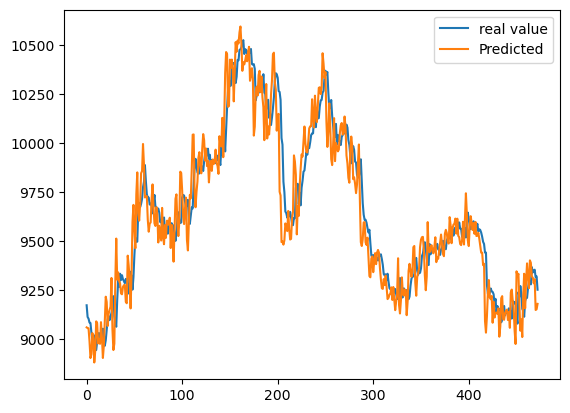

In [ ]:
# line plot of observed vs predicted
pyplot.plot(exp, label='real value')
pyplot.plot(predictions, label='Predicted')
pyplot.legend()
pyplot.show()